# <a id='toc1_'></a>[Direct Emission Scheme for Distributed Quantum Error Correction - Results](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Direct Emission Scheme for Distributed Quantum Error Correction - Results](#toc1_)    
- [Quickly test the GHZ states from various protocols](#toc2_)    
- [Convergence of the distillation protocols](#toc3_)    
- [Comparison of various direct emission protocols](#toc4_)    
  - [Modeling of previous Bell-pair fusion scheme ($k=11$) with WT4 Set-3 FP](#toc4_1_)    
  - [Bright state parameter influence](#toc4_2_)    
    - [Data](#toc4_2_1_)    
    - [Plot](#toc4_2_2_)    
  - [Improving coherence times](#toc4_3_)    
    - [Data](#toc4_3_1_)    
    - [Plot](#toc4_3_2_)    
  - [Hardware parameters' improvement](#toc4_4_)    
    - [Data](#toc4_4_1_)    
    - [Plot](#toc4_4_2_)    
  - [Heatmaps for hardware and coherence parameters for the performance](#toc4_5_)    
    - [Data](#toc4_5_1_)    
    - [Plot](#toc4_5_2_)    
  - [Heatmaps for bright state parameters for raw and distillation resource](#toc4_6_)    
    - [Data](#toc4_6_1_)    
    - [Plot](#toc4_6_2_)    
- [Threshold calculations for direct emission scheme](#toc5_)    
  - [Shorten the names of superoperator files](#toc5_1_)    
  - [Threshold plots from the generated data](#toc5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Quickly test the GHZ states from various protocols](#toc0_)

In [ ]:
# Testing low amount of shots for quick calculations
from circuit_simulation.circuit_simulator import QuantumCircuit
import numpy as np

shots = 5

coh_time = 10
pg = 0.001

bell_pair_parameters = {"ent_prot":"double_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":0.05} # FP
# bell_pair_parameters = {"ent_prot":"single_click","F_prep":1,"p_DE":0.00,"mu":1,"lambda":1,"eta":1,"alpha":0.05} # Noiseless

qc = QuantumCircuit(0, p_g=pg, network_noise_type=107, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=False, 
                    bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time, T1n_idle=coh_time, 
                    T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)

# <a id='toc3_'></a>[Convergence of the distillation protocols](#toc0_)

Simulation data generation for the convergence of the distillation protocols.

In [ ]:
# Convergence plots
import numpy as np
from circuit_simulation.circuit_simulator import QuantumCircuit
import json
from datetime import datetime

# Get current date and time in the format YYYYMMDDHHMMSS
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

coh_time = 10
pg = 0.001
bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":0.05}

# Define the number of iterations
# shots = np.array([100, 500, 1000, 1500, 2000, 2500, 4000])  # Example: 1 to 20 shots
shots = np.array([5, 10, 50, 100])  # Example: 1 to 20 shots

# Initialize arrays to store results
success_probabilities = []
infidelities = []
success_prob_std = []
infidelity_std = []
statistics = []

# Simulate success probability and infidelity for each iteration
for shot in shots:
    qc = QuantumCircuit(0, p_g=pg, network_noise_type=103, only_GHZ=True, shots_emission_direct=shot, 
                        bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time, T1n_idle=coh_time, 
                        T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    success_probabilities.append(qc.p_link)
    infidelities.append(1 - qc.F_link)  # Calculate infidelity as 1 - fidelity
    statistics.append(qc.emission_direct_statistics)
    
# Calculate mean and standard deviation
success_prob_std = [np.std(np.array(i["p_link"])) for i in statistics]
infidelity_std = [np.std(1-np.array(i["F_link"])) for i in statistics]

# Save results to a JSON file for later plotting
results_dict = {
    "iterations": shots.tolist(),
    "success_probabilities": success_probabilities,
    "success_prob_std": success_prob_std,
    "infidelities": infidelities,
    "infidelity_std": infidelity_std
}


convergence_data = f".\output_data\simulation_data\{timestamp}_data_convergence.json"
with open(convergence_data, "w") as f:
    json.dump(results_dict, f, indent=2)

Plotter for the convergence of the distillation protocols.

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Load the data from the JSON file
convergence_data = rf".\output_data\simulation_data\snellius_results\0_convergence_of_shots\2025_06_11_13_04_19_data_convergence.json"
with open(convergence_data, "r") as f:
    data = json.load(f)
# Extract data
shots = np.array(data["iterations"])
success_probabilities = np.array(data["success_probabilities"])
success_prob_std = np.array(data["success_prob_std"])
infidelities = np.array(data["infidelities"])
infidelity_std = np.array(data["infidelity_std"])


# Plot success probability with error bars
fig, ax = plt.subplots(figsize=(12, 6))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the data with error bars
ax.errorbar(shots, success_probabilities, yerr=[i/np.sqrt(j) for i,j in zip(success_prob_std,shots)], fmt='o-', label='Success Probability', capsize=5, color='#1f77b4', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(shots, infidelities, yerr=[i/np.sqrt(j) for i,j in zip(infidelity_std,shots)], fmt='s-', label='Infidelity', capsize=5, color='#ff7f0e', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)

# Set labels, title, and legend
ax.set_xlabel('Number of Iterations', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Value', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_title('Convergence of Success Probability and Infidelity', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=14, prop={'family': 'Cambria'})

# Enable grid
ax.grid(True)
# Set y-axis to log scale
ax.set_yscale('log')
# Show the plot
plt.show()
# Save the plot
fig.savefig(convergence_data.replace(".json", "_plot.pdf").replace("simulation_data","figures"), dpi=300, bbox_inches='tight')

# <a id='toc4_'></a>[Comparison of various direct emission protocols](#toc0_)

## <a id='toc4_1_'></a>[Modeling of previous Bell-pair fusion scheme ($k=11$) with WT4 Set-3 FP](#toc0_)

Description of the fusion-distillation protocol:

![alt text](fusion_k_11_protocol.png)

This protocol is explicitly modelled as `network_noise_type`$= 105$ in the `_construct_noisy_bell_pair_state` module in `circuit_simulator.py`. This can be called and used to compare with other distillation protocols!

In [ ]:
from circuit_simulation.circuit_simulator import QuantumCircuit
from circuit_simulation.stabilizer_measurement_protocols.run_protocols import additional_parsing_of_arguments
from circuit_simulation.stabilizer_measurement_protocols.auto_generated_stabilizer_measurement_protocols import create_protocol_recipe_quantum_circuit

fusion_protocol_file = rf".\circuit_simulation\protocol_recipes\dyn_prot_NA1_4_11_8"

# Simulation parameters
coh_time = 10 # Set-3 coherence times
pg = 0.001 # Gate error for all operations
bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":0.05} # FP

args = {"protocol": 'auto_generated', 'protocol_recipes_file': fusion_protocol_file, "argument_file": "argument_file_em_fusion.txt",
        "parameter_select": None}

additional_parsing_of_arguments(**args)

# qc, _ = create_protocol_recipe_quantum_circuit(fusion_protocol, pbar=None)

## <a id='toc4_2_'></a>[Bright state parameter influence](#toc0_)

### <a id='toc4_2_1_'></a>[Data](#toc0_)

Simulation data generation for the bright state parameter influence.

In [ ]:
import numpy as np
from circuit_simulation.circuit_simulator import QuantumCircuit

from datetime import datetime

# Get current date and time in the format YYYYMMDDHHMMSS
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

# Bright State parameter alpha
alpha_range = np.arange(0.050, 0.525, 0.05)

# Coherence times
coh_time = 10 # Set-3

# Gate error in GHZ state
pg = 0.001

# shots
shots = 2

# Plot the curves with specified markers and colors
raw_p = []
raw_inf = []
dc_state_p = []
dc_state_inf = []
basic_state_p = []
basic_state_inf = []
basic_state_statistics = []
w_state_p = []
w_state_inf = []
w_state_statistics = []
bell_sc_distilled_state_p = []
bell_sc_distilled_state_inf = []
bell_sc_distilled_state_statistics = []
bell_dc_distilled_state_p = []
bell_dc_distilled_state_inf = []
bell_dc_distilled_state_statistics = []
w_to_GHZ_distilled_state_p = []
w_to_GHZ_distilled_state_inf = []
w_to_GHZ_distilled_state_statistics = []
w_to_GHZ_dc_state_p = []
w_to_GHZ_dc_state_inf = []

pnr_raw_p = []
pnr_raw_inf = []
pnr_dc_state_p = []
pnr_dc_state_inf = []
pnr_basic_state_p = []
pnr_basic_state_inf = []
pnr_basic_state_statistics = []
pnr_w_state_p = []
pnr_w_state_inf = []
pnr_w_state_statistics = []
pnr_bell_sc_distilled_state_p = []
pnr_bell_sc_distilled_state_inf = []
pnr_bell_sc_distilled_state_statistics = []
pnr_bell_dc_distilled_state_p = []
pnr_bell_dc_distilled_state_inf = []
pnr_bell_dc_distilled_state_statistics = []
pnr_w_to_GHZ_distilled_state_p = []
pnr_w_to_GHZ_distilled_state_inf = []
pnr_w_to_GHZ_distilled_state_statistics = []
pnr_w_to_GHZ_dc_state_p = []
pnr_w_to_GHZ_dc_state_inf = []

# For non-photon-number resolution 
for alpha in alpha_range:
    print(f"alpha:{alpha}")
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":1,"p_DE":0.01,"mu":0.97,"lambda":1,"eta":0.4474,"alpha":alpha}
    raw_state_qc = QuantumCircuit(0,network_noise_type=100, only_GHZ=True, shots_emission_direct=shots, p_g=pg, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    raw_p.append(raw_state_qc.p_link)
    raw_inf.append(1-raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(0,network_noise_type=101, only_GHZ=True, shots_emission_direct=shots, p_g=pg, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(0,network_noise_type=103, only_GHZ=True, shots_emission_direct=shots, p_g=pg, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_inf.append(1-basic_distilled_state_qc.F_link)
    basic_state_statistics.append(basic_distilled_state_qc.emission_direct_statistics)

    w_distilled_state_qc = QuantumCircuit(0,network_noise_type=104, only_GHZ=True, shots_emission_direct=shots, p_g=pg, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    w_state_p.append(w_distilled_state_qc.p_link)
    w_state_inf.append(1-w_distilled_state_qc.F_link)
    w_state_statistics.append(w_distilled_state_qc.emission_direct_statistics)

    bell_sc_distilled_state_qc = QuantumCircuit(0,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, p_g=pg, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)
    bell_sc_distilled_state_statistics.append(bell_sc_distilled_state_qc.emission_direct_statistics)

    bell_dc_pair_parameters = bell_pair_parameters.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(0,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, p_g=pg, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)
    bell_dc_distilled_state_statistics.append(bell_dc_distilled_state_qc.emission_direct_statistics)

    # w_to_GHZ distilled protocol
    w_to_GHZ_distilled_state_qc = QuantumCircuit(0, network_noise_type=107, only_GHZ=True, shots_emission_direct=shots, p_g=pg, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    w_to_GHZ_distilled_state_p.append(w_to_GHZ_distilled_state_qc.p_link)
    w_to_GHZ_distilled_state_inf.append(1-w_to_GHZ_distilled_state_qc.F_link)
    w_to_GHZ_distilled_state_statistics.append(w_to_GHZ_distilled_state_qc.emission_direct_statistics)

    # w_to_GHZ DC protocol
    w_to_GHZ_dc_state_qc = QuantumCircuit(0, network_noise_type=106, only_GHZ=True, shots_emission_direct=shots, p_g=pg, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    w_to_GHZ_dc_state_p.append(w_to_GHZ_dc_state_qc.p_link)
    w_to_GHZ_dc_state_inf.append(1-w_to_GHZ_dc_state_qc.F_link)

# For photon number resolving detectors below:
for alpha in alpha_range:
    print(f"alpha:{alpha}")
    bell_pair_parameters = {"ent_prot":"single_click","F_prep":1,"p_DE":0.01,"mu":0.97,"lambda":1,"eta":0.4474,"alpha":alpha}
    raw_state_qc = QuantumCircuit(0,network_noise_type=100, only_GHZ=True, shots_emission_direct=shots, p_g=pg, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_raw_p.append(raw_state_qc.p_link)
    pnr_raw_inf.append(1-raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(0,network_noise_type=101, only_GHZ=True, shots_emission_direct=shots, p_g=pg, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_dc_state_p.append(dc_state_qc.p_link)
    pnr_dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(0,network_noise_type=103, only_GHZ=True, shots_emission_direct=shots, p_g=pg, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_basic_state_p.append(basic_distilled_state_qc.p_link)
    pnr_basic_state_inf.append(1-basic_distilled_state_qc.F_link)
    pnr_basic_state_statistics.append(basic_distilled_state_qc.emission_direct_statistics)

    w_distilled_state_qc = QuantumCircuit(0,network_noise_type=104, only_GHZ=True, shots_emission_direct=shots, p_g=pg, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_w_state_p.append(w_distilled_state_qc.p_link)
    pnr_w_state_inf.append(1-w_distilled_state_qc.F_link)
    pnr_w_state_statistics.append(w_distilled_state_qc.emission_direct_statistics)

    bell_sc_distilled_state_qc = QuantumCircuit(0,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, p_g=pg, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    pnr_bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)
    pnr_bell_sc_distilled_state_statistics.append(bell_sc_distilled_state_qc.emission_direct_statistics)

    bell_dc_pair_parameters = bell_pair_parameters.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(0,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, p_g=pg, photon_number_resolution=True,bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    pnr_bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)
    pnr_bell_dc_distilled_state_statistics.append(bell_dc_distilled_state_qc.emission_direct_statistics)

    # w_to_GHZ distilled protocol
    w_to_GHZ_distilled_state_qc = QuantumCircuit(0, network_noise_type=107, only_GHZ=True, shots_emission_direct=shots, p_g=pg, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    pnr_w_to_GHZ_distilled_state_p.append(w_to_GHZ_distilled_state_qc.p_link)
    pnr_w_to_GHZ_distilled_state_inf.append(1-w_to_GHZ_distilled_state_qc.F_link)
    pnr_w_to_GHZ_distilled_state_statistics.append(w_to_GHZ_distilled_state_qc.emission_direct_statistics)

    # w_to_GHZ DC protocol
    w_to_GHZ_dc_state_qc = QuantumCircuit(0, network_noise_type=106, only_GHZ=True, shots_emission_direct=shots, p_g=pg, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    pnr_w_to_GHZ_dc_state_p.append(w_to_GHZ_dc_state_qc.p_link)
    pnr_w_to_GHZ_dc_state_inf.append(1-w_to_GHZ_dc_state_qc.F_link)

# Filter out nan values
valid_indices = ~np.isnan(raw_inf) & ~np.isnan(dc_state_inf) & ~np.isnan(basic_state_inf) & ~np.isnan(w_state_inf) & ~np.isnan(bell_sc_distilled_state_inf) & ~np.isnan(bell_dc_distilled_state_inf) & ~np.isnan(w_to_GHZ_distilled_state_inf) & ~np.isnan(w_to_GHZ_dc_state_inf)
alpha_filtered = np.array(alpha_range)[valid_indices]
raw_inf_filtered = np.array(raw_inf)[valid_indices]
raw_p_filtered = np.array(raw_p)[valid_indices]
dc_state_inf_filtered = np.array(dc_state_inf)[valid_indices]
dc_state_p_filtered = np.array(dc_state_p)[valid_indices]
basic_state_inf_filtered = np.array(basic_state_inf)[valid_indices]
basic_state_p_filtered = np.array(basic_state_p)[valid_indices]
basic_state_statistics_filtered = np.array(basic_state_statistics)[valid_indices]
w_state_inf_filtered = np.array(w_state_inf)[valid_indices]
w_state_p_filtered = np.array(w_state_p)[valid_indices]
w_state_statistics_filtered = np.array(w_state_statistics)[valid_indices]
bell_sc_distilled_state_inf_filtered = np.array(bell_sc_distilled_state_inf)[valid_indices]
bell_sc_distilled_state_p_filtered = np.array(bell_sc_distilled_state_p)[valid_indices]
bell_sc_distilled_state_statistics_filtered = np.array(bell_sc_distilled_state_statistics)[valid_indices]
bell_dc_distilled_state_inf_filtered = np.array(bell_dc_distilled_state_inf)[valid_indices]
bell_dc_distilled_state_p_filtered = np.array(bell_dc_distilled_state_p)[valid_indices]
bell_dc_distilled_state_statistics_filtered = np.array(bell_dc_distilled_state_statistics)[valid_indices]
w_to_GHZ_distilled_state_inf_filtered = np.array(w_to_GHZ_distilled_state_inf)[valid_indices]
w_to_GHZ_distilled_state_p_filtered = np.array(w_to_GHZ_distilled_state_p)[valid_indices]
w_to_GHZ_distilled_state_statistics_filtered = np.array(w_to_GHZ_distilled_state_statistics)[valid_indices]
w_to_GHZ_dc_state_inf_filtered = np.array(w_to_GHZ_dc_state_inf)[valid_indices]
w_to_GHZ_dc_state_p_filtered = np.array(w_to_GHZ_dc_state_p)[valid_indices]

# Filter out nan values for photon number resolving detectors
valid_indices_pnr = ~np.isnan(pnr_raw_inf) & ~np.isnan(pnr_dc_state_inf) & ~np.isnan(pnr_basic_state_inf) & ~np.isnan(pnr_w_state_inf) & ~np.isnan(pnr_bell_sc_distilled_state_inf) & ~np.isnan(pnr_bell_dc_distilled_state_inf) & ~np.isnan(pnr_w_to_GHZ_distilled_state_inf) & ~np.isnan(pnr_w_to_GHZ_dc_state_inf)
alpha_filtered_pnr = np.array(alpha_range)[valid_indices_pnr]
pnr_raw_inf_filtered = np.array(pnr_raw_inf)[valid_indices_pnr]
pnr_raw_p_filtered = np.array(pnr_raw_p)[valid_indices_pnr]
pnr_dc_state_inf_filtered = np.array(pnr_dc_state_inf)[valid_indices_pnr]
pnr_dc_state_p_filtered = np.array(pnr_dc_state_p)[valid_indices_pnr]
pnr_basic_state_inf_filtered = np.array(pnr_basic_state_inf)[valid_indices_pnr]
pnr_basic_state_p_filtered = np.array(pnr_basic_state_p)[valid_indices_pnr]
pnr_basic_state_statistics_filtered = np.array(pnr_basic_state_statistics)[valid_indices_pnr]
pnr_w_state_inf_filtered = np.array(pnr_w_state_inf)[valid_indices_pnr]
pnr_w_state_p_filtered = np.array(pnr_w_state_p)[valid_indices_pnr]
pnr_w_state_statistics_filtered = np.array(pnr_w_state_statistics)[valid_indices_pnr]
pnr_bell_sc_distilled_state_inf_filtered = np.array(pnr_bell_sc_distilled_state_inf)[valid_indices_pnr]
pnr_bell_sc_distilled_state_p_filtered = np.array(pnr_bell_sc_distilled_state_p)[valid_indices_pnr]
pnr_bell_sc_distilled_state_statistics_filtered = np.array(pnr_bell_sc_distilled_state_statistics)[valid_indices_pnr]
pnr_bell_dc_distilled_state_inf_filtered = np.array(pnr_bell_dc_distilled_state_inf)[valid_indices_pnr]
pnr_bell_dc_distilled_state_p_filtered = np.array(pnr_bell_dc_distilled_state_p)[valid_indices_pnr]
pnr_bell_dc_distilled_state_statistics_filtered = np.array(pnr_bell_dc_distilled_state_statistics)[valid_indices_pnr]
pnr_w_to_GHZ_distilled_state_inf_filtered = np.array(pnr_w_to_GHZ_distilled_state_inf)[valid_indices_pnr]
pnr_w_to_GHZ_distilled_state_p_filtered = np.array(pnr_w_to_GHZ_distilled_state_p)[valid_indices_pnr]
pnr_w_to_GHZ_distilled_state_statistics_filtered = np.array(pnr_w_to_GHZ_distilled_state_statistics)[valid_indices_pnr]
pnr_w_to_GHZ_dc_state_inf_filtered = np.array(pnr_w_to_GHZ_dc_state_inf)[valid_indices_pnr]
pnr_w_to_GHZ_dc_state_p_filtered = np.array(pnr_w_to_GHZ_dc_state_p)[valid_indices_pnr]

# Store the results in a dictionary for easy access, including alpha values
results = {
    "alpha_filtered": alpha_filtered.tolist(),
    "raw_inf_filtered": raw_inf_filtered.tolist(),
    "raw_p_filtered": raw_p_filtered.tolist(),
    "dc_state_inf_filtered": dc_state_inf_filtered.tolist(),
    "dc_state_p_filtered": dc_state_p_filtered.tolist(),
    "basic_state_inf_filtered": basic_state_inf_filtered.tolist(),
    "basic_state_p_filtered": basic_state_p_filtered.tolist(),
    "basic_state_statistics_filtered": basic_state_statistics_filtered.tolist(),
    "w_state_inf_filtered": w_state_inf_filtered.tolist(),
    "w_state_p_filtered": w_state_p_filtered.tolist(),
    "w_state_statistics_filtered": w_state_statistics_filtered.tolist(),
    "bell_sc_distilled_state_inf_filtered": bell_sc_distilled_state_inf_filtered.tolist(),
    "bell_sc_distilled_state_p_filtered": bell_sc_distilled_state_p_filtered.tolist(),
    "bell_sc_distilled_state_statistics_filtered": bell_sc_distilled_state_statistics_filtered.tolist(),
    "bell_dc_distilled_state_inf_filtered": bell_dc_distilled_state_inf_filtered.tolist(),
    "bell_dc_distilled_state_p_filtered": bell_dc_distilled_state_p_filtered.tolist(),
    "bell_dc_distilled_state_statistics_filtered": bell_dc_distilled_state_statistics_filtered.tolist(),
    "w_to_GHZ_distilled_state_inf_filtered": w_to_GHZ_distilled_state_inf_filtered.tolist(),
    "w_to_GHZ_distilled_state_p_filtered": w_to_GHZ_distilled_state_p_filtered.tolist(),
    "w_to_GHZ_distilled_state_statistics_filtered": w_to_GHZ_distilled_state_statistics_filtered.tolist(),
    "w_to_GHZ_dc_state_inf_filtered": w_to_GHZ_dc_state_inf_filtered.tolist(),
    "w_to_GHZ_dc_state_p_filtered": w_to_GHZ_dc_state_p_filtered.tolist(),

    "alpha_filtered_pnr": alpha_filtered_pnr.tolist(),
    "pnr_raw_inf_filtered": pnr_raw_inf_filtered.tolist(),
    "pnr_raw_p_filtered": pnr_raw_p_filtered.tolist(),
    "pnr_dc_state_inf_filtered": pnr_dc_state_inf_filtered.tolist(),
    "pnr_dc_state_p_filtered": pnr_dc_state_p_filtered.tolist(),
    "pnr_basic_state_inf_filtered": pnr_basic_state_inf_filtered.tolist(),
    "pnr_basic_state_p_filtered": pnr_basic_state_p_filtered.tolist(),
    "pnr_basic_state_statistics_filtered": pnr_basic_state_statistics_filtered.tolist(),
    "pnr_w_state_inf_filtered": pnr_w_state_inf_filtered.tolist(),
    "pnr_w_state_p_filtered": pnr_w_state_p_filtered.tolist(),
    "pnr_w_state_statistics_filtered": pnr_w_state_statistics_filtered.tolist(),
    "pnr_bell_sc_distilled_state_inf_filtered": pnr_bell_sc_distilled_state_inf_filtered.tolist(),
    "pnr_bell_sc_distilled_state_p_filtered": pnr_bell_sc_distilled_state_p_filtered.tolist(),
    "pnr_bell_sc_distilled_state_statistics_filtered": pnr_bell_sc_distilled_state_statistics_filtered.tolist(),
    "pnr_bell_dc_distilled_state_inf_filtered": pnr_bell_dc_distilled_state_inf_filtered.tolist(),
    "pnr_bell_dc_distilled_state_p_filtered": pnr_bell_dc_distilled_state_p_filtered.tolist(),
    "pnr_bell_dc_distilled_state_statistics_filtered": pnr_bell_dc_distilled_state_statistics_filtered.tolist(),
    "pnr_w_to_GHZ_distilled_state_inf_filtered": pnr_w_to_GHZ_distilled_state_inf_filtered.tolist(),
    "pnr_w_to_GHZ_distilled_state_p_filtered": pnr_w_to_GHZ_distilled_state_p_filtered.tolist(),
    "pnr_w_to_GHZ_distilled_state_statistics_filtered": pnr_w_to_GHZ_distilled_state_statistics_filtered.tolist(),
    "pnr_w_to_GHZ_dc_state_inf_filtered": pnr_w_to_GHZ_dc_state_inf_filtered.tolist(),
    "pnr_w_to_GHZ_dc_state_p_filtered": pnr_w_to_GHZ_dc_state_p_filtered.tolist()
}

# Save the data to a json file
import json
bright_state_parameter_influence_data =rf'.\output_data\simulation_data\{timestamp}_data_bright_state_parameter_influence_shots_{shots}_Fprep_{bell_pair_parameters["F_prep"]}_pDE_{bell_pair_parameters["p_DE"]}_mu_{bell_pair_parameters["mu"]}_eta_{bell_dc_pair_parameters["eta"]}_cohtime_{coh_time}_pg_{pg}.json'
with open(bright_state_parameter_influence_data, 'w') as f:
    json.dump(results, f, indent=4)

### <a id='toc4_2_2_'></a>[Plot](#toc0_)

Plotter for the data generated for the bright state parameter influence.

c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\ssi

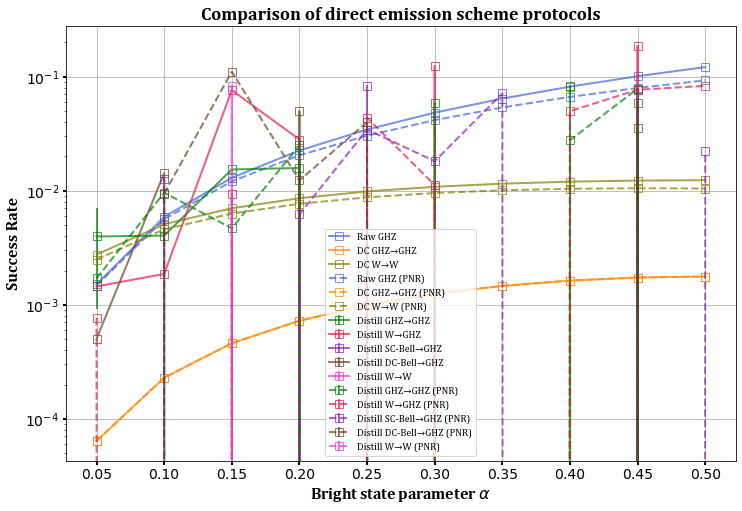

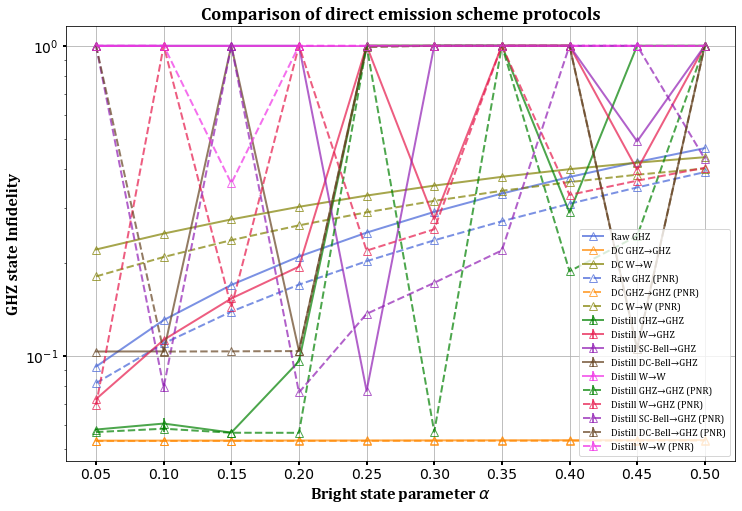

In [9]:
import matplotlib.pyplot as plt
import json
import numpy as np
import re

# Import the data from the json file
bright_state_parameter_influence_data = rf".\output_data\simulation_data\2025_06_29_20_28_26_data_bright_state_parameter_influence_shots_2_Fprep_1_pDE_0.01_mu_0.97_eta_0.4474_cohtime_10_pg_0.001.json"
with open(bright_state_parameter_influence_data, "r") as json_file:
    data = json.load(json_file)

# Extract the data from the json file
alpha_range = data["alpha_filtered"]
raw_inf = data["raw_inf_filtered"]
raw_p = data["raw_p_filtered"]
dc_state_inf = data["dc_state_inf_filtered"]
dc_state_p = data["dc_state_p_filtered"]
basic_state_inf = data["basic_state_inf_filtered"]
basic_state_p = data["basic_state_p_filtered"]
basic_state_statistics = data["basic_state_statistics_filtered"]
w_state_inf = data["w_state_inf_filtered"]
w_state_p = data["w_state_p_filtered"]
w_state_statistics = data["w_state_statistics_filtered"]
bell_sc_distilled_state_inf = data["bell_sc_distilled_state_inf_filtered"]
bell_sc_distilled_state_p = data["bell_sc_distilled_state_p_filtered"]
bell_sc_distilled_state_statistics = data["bell_sc_distilled_state_statistics_filtered"]
bell_dc_distilled_state_inf = data["bell_dc_distilled_state_inf_filtered"]
bell_dc_distilled_state_p = data["bell_dc_distilled_state_p_filtered"]
bell_dc_distilled_state_statistics = data["bell_dc_distilled_state_statistics_filtered"]
w_to_GHZ_distilled_state_inf = data["w_to_GHZ_distilled_state_inf_filtered"]
w_to_GHZ_distilled_state_p = data["w_to_GHZ_distilled_state_p_filtered"]
w_to_GHZ_distilled_state_statistics = data["w_to_GHZ_distilled_state_statistics_filtered"]
w_to_GHZ_dc_state_inf = data["w_to_GHZ_dc_state_inf_filtered"]
w_to_GHZ_dc_state_p = data["w_to_GHZ_dc_state_p_filtered"]

pnr_alpha_range = data["alpha_filtered_pnr"]
pnr_raw_inf = data["pnr_raw_inf_filtered"]
pnr_raw_p = data["pnr_raw_p_filtered"]
pnr_dc_state_inf = data["pnr_dc_state_inf_filtered"]
pnr_dc_state_p = data["pnr_dc_state_p_filtered"]
pnr_basic_state_inf = data["pnr_basic_state_inf_filtered"]
pnr_basic_state_p = data["pnr_basic_state_p_filtered"]
pnr_basic_state_statistics = data["pnr_basic_state_statistics_filtered"]
pnr_w_state_inf = data["pnr_w_state_inf_filtered"]
pnr_w_state_p = data["pnr_w_state_p_filtered"]
pnr_w_state_statistics = data["pnr_w_state_statistics_filtered"]
pnr_bell_sc_distilled_state_inf = data["pnr_bell_sc_distilled_state_inf_filtered"]
pnr_bell_sc_distilled_state_p = data["pnr_bell_sc_distilled_state_p_filtered"]
pnr_bell_sc_distilled_state_statistics = data["pnr_bell_sc_distilled_state_statistics_filtered"]
pnr_bell_dc_distilled_state_inf = data["pnr_bell_dc_distilled_state_inf_filtered"]
pnr_bell_dc_distilled_state_p = data["pnr_bell_dc_distilled_state_p_filtered"]
pnr_bell_dc_distilled_state_statistics = data["pnr_bell_dc_distilled_state_statistics_filtered"]
pnr_w_to_GHZ_distilled_state_inf = data["pnr_w_to_GHZ_distilled_state_inf_filtered"]
pnr_w_to_GHZ_distilled_state_p = data["pnr_w_to_GHZ_distilled_state_p_filtered"]
pnr_w_to_GHZ_distilled_state_statistics = data["pnr_w_to_GHZ_distilled_state_statistics_filtered"]
pnr_w_to_GHZ_dc_state_inf = data["pnr_w_to_GHZ_dc_state_inf_filtered"]
pnr_w_to_GHZ_dc_state_p = data["pnr_w_to_GHZ_dc_state_p_filtered"]

# Find shots from the file name
match_shots = re.search(r'shots_(\d+)', bright_state_parameter_influence_data)
shots = int(match_shots.group(1))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plotting the results
# Success rates plotting
ax.plot(alpha_range, raw_p, marker='s', color='#4363d8', label='Raw GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)      # Dark pastel blue
ax.plot(alpha_range, dc_state_p, marker='s', color='#ff8800', label='DC GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)   # Dark pastel orange
ax.errorbar(alpha_range, basic_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in basic_state_statistics], marker='s', color='#008000', label='Distill GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel green
ax.errorbar(alpha_range, w_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in w_state_statistics], marker='s', color='#e6194b', label='Distill W→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel red
ax.errorbar(alpha_range, bell_sc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in bell_sc_distilled_state_statistics], marker='s', color='#911eb4', label='Distill SC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel purple
ax.errorbar(alpha_range, bell_dc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in bell_dc_distilled_state_statistics], marker='s', color='#654321', label='Distill DC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel brown
ax.errorbar(alpha_range, w_to_GHZ_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in w_to_GHZ_distilled_state_statistics], marker='s', color='#f032e6', label='Distill W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel pink
ax.plot(alpha_range, w_to_GHZ_dc_state_p, marker='s', color='#808000', label='DC W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel olive

ax.plot(alpha_range, pnr_raw_p, marker='s', color='#4363d8', label='Raw GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.plot(alpha_range, pnr_dc_state_p, marker='s', color='#ff8800', label='DC GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(alpha_range, pnr_basic_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_basic_state_statistics], marker='s', color='#008000', label='Distill GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(alpha_range, pnr_w_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_w_state_statistics], marker='s', color='#e6194b', label='Distill W→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(alpha_range, pnr_bell_sc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_bell_sc_distilled_state_statistics], marker='s', color='#911eb4', label='Distill SC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(alpha_range, pnr_bell_dc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_bell_dc_distilled_state_statistics], marker='s', color='#654321', label='Distill DC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(alpha_range, pnr_w_to_GHZ_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_w_to_GHZ_distilled_state_statistics], marker='s', color='#f032e6', label='Distill W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.plot(alpha_range, pnr_w_to_GHZ_dc_state_p, marker='s', color='#808000', label='DC W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)

# Enable grid
ax.grid(True)

# Set y-axis to log scale
ax.set_yscale('log')

# Set bold axis ticks and labels
alpha_ticks = np.arange(0.05, 0.55, 0.05)
ax.set_xticks(alpha_ticks)
ax.set_xticklabels([f'{alpha:.2f}' for alpha in alpha_ticks])
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Bright state parameter $\alpha$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Rate', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

# Infidelity plotting

fig_2, ax_2 = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig_2.patch.set_facecolor('white')
ax_2.set_facecolor('white')

ax_2.plot(alpha_range, raw_inf, marker='^', color='#4363d8', label='Raw GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.plot(alpha_range, dc_state_inf, marker='^', color='#ff8800', label='DC GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(alpha_range, basic_state_inf, yerr=[np.std(np.array(i["F_link"]))/np.sqrt(shots) for i in basic_state_statistics], marker='^', color='#008000', label='Distill GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(alpha_range, w_state_inf, yerr=[np.std(np.array(i["F_link"]))/np.sqrt(shots) for i in w_state_statistics], marker='^', color='#e6194b', label='Distill W→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(alpha_range, bell_sc_distilled_state_inf, yerr=[np.std(np.array(i["F_link"]))/np.sqrt(shots) for i in bell_sc_distilled_state_statistics], marker='^', color='#911eb4', label='Distill SC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(alpha_range, bell_dc_distilled_state_inf, yerr=[np.std(np.array(i["F_link"]))/np.sqrt(shots) for i in bell_dc_distilled_state_statistics], marker='^', color='#654321', label='Distill DC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(alpha_range, w_to_GHZ_distilled_state_inf, yerr=[np.std(np.array(i["F_link"]))/np.sqrt(shots) for i in w_to_GHZ_distilled_state_statistics], marker='^', color='#f032e6', label='Distill W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.plot(alpha_range, w_to_GHZ_dc_state_inf, marker='^', color='#808000', label='DC W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)

ax_2.plot(alpha_range, pnr_raw_inf, marker='^', color='#4363d8', label='Raw GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.plot(alpha_range, pnr_dc_state_inf, marker='^', color='#ff8800', label='DC GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(alpha_range, pnr_basic_state_inf, yerr=[np.std(np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_basic_state_statistics], marker='^', color='#008000', label='Distill GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(alpha_range, pnr_w_state_inf, yerr=[np.std(np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_w_state_statistics], marker='^', color='#e6194b', label='Distill W→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(alpha_range, pnr_bell_sc_distilled_state_inf, yerr=[np.std(np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_bell_sc_distilled_state_statistics], marker='^', color='#911eb4', label='Distill SC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(alpha_range, pnr_bell_dc_distilled_state_inf, yerr=[np.std(np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_bell_dc_distilled_state_statistics], marker='^', color='#654321', label='Distill DC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(alpha_range, pnr_w_to_GHZ_distilled_state_inf, yerr=[np.std(np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_w_to_GHZ_distilled_state_statistics], marker='^', color='#f032e6', label='Distill W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.plot(alpha_range, pnr_w_to_GHZ_dc_state_inf, marker='^', color='#808000', label='DC W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)

# Enable grid
ax_2.grid(True)

# Set y-axis to log scale
ax_2.set_yscale('log')

# Set bold axis ticks and labels
alpha_ticks = np.arange(0.05, 0.55, 0.05)
ax_2.set_xticks(alpha_ticks)
ax_2.set_xticklabels([f'{alpha:.2f}' for alpha in alpha_ticks])
ax_2.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax_2.set_xlabel(r'Bright state parameter $\alpha$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.set_ylabel('GHZ state Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax_2.set_title('Comparison of direct emission scheme protocols', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

# Show the plot
plt.show()

# Save the figures as PDFs
fig.savefig(bright_state_parameter_influence_data.replace(".json", "_plot_success_rates.pdf").replace("simulation_data","figures"), dpi=300, bbox_inches='tight')
fig_2.savefig(bright_state_parameter_influence_data.replace(".json", "_plot_infidelity.pdf").replace("simulation_data","figures"), dpi=300, bbox_inches='tight')

## <a id='toc4_3_'></a>[Improving coherence times](#toc0_)

### <a id='toc4_3_1_'></a>[Data](#toc0_)

Simulation data generation for coherence times improvement.

In [ ]:
import numpy as np
from circuit_simulation.circuit_simulator import QuantumCircuit
from datetime import datetime
import json

# Get current date and time in the format YYYYMMDDHHMMSS
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

# Shots
shots = 1

# Operating parameter alpha
alpha = 0.05

# Gate error in GHZ generation
pg = 0.001

# Coherence times improvement
coh_times = [0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100]

# Bell pair parameters
bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha}
dc_bell_pair_parameters = {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":0.5} # Direct double-click scheme
bell_dc_pair_parameters = {"ent_prot":"double_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha} # Another bell pair protocol with double-click elemetray links

# Plot the curves with specified markers and colors
raw_p = []
raw_inf = []
dc_state_p = []
dc_state_inf = []
basic_state_p = []
basic_state_inf = []
basic_state_statistics = []
w_state_p = []
w_state_inf = []
w_state_statistics = []
bell_sc_distilled_state_p = []
bell_sc_distilled_state_inf = []
bell_sc_distilled_state_statistics = []
bell_dc_distilled_state_p = []
bell_dc_distilled_state_inf = []
bell_dc_distilled_state_statistics = []
w_to_GHZ_distilled_state_p = []
w_to_GHZ_distilled_state_inf = []
w_to_GHZ_distilled_state_statistics = []
w_to_GHZ_dc_state_p = []
w_to_GHZ_dc_state_inf = []

pnr_raw_p = []
pnr_raw_inf = []
pnr_dc_state_p = []
pnr_dc_state_inf = []
pnr_basic_state_p = []
pnr_basic_state_inf = []
pnr_basic_state_statistics = []
pnr_w_state_p = []
pnr_w_state_inf = []
pnr_w_state_statistics = []
pnr_bell_sc_distilled_state_p = []
pnr_bell_sc_distilled_state_inf = []
pnr_bell_sc_distilled_state_statistics = []
pnr_bell_dc_distilled_state_p = []
pnr_bell_dc_distilled_state_inf = []
pnr_bell_dc_distilled_state_statistics = []
pnr_w_to_GHZ_distilled_state_p = []
pnr_w_to_GHZ_distilled_state_inf = []
pnr_w_to_GHZ_distilled_state_statistics = []
pnr_w_to_GHZ_dc_state_p = []
pnr_w_to_GHZ_dc_state_inf = []

for coh_time in coh_times:
    print(f"Coherence time:{coh_time}")
    raw_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=100, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    raw_p.append(raw_state_qc.p_link)
    raw_inf.append(1-raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=101, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True,bell_pair_parameters=dc_bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=103, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_inf.append(1-basic_distilled_state_qc.F_link)
    basic_state_statistics.append(basic_distilled_state_qc.emission_direct_statistics)

    w_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=104, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    w_state_p.append(w_distilled_state_qc.p_link)
    w_state_inf.append(1-w_distilled_state_qc.F_link)
    w_state_statistics.append(w_distilled_state_qc.emission_direct_statistics)

    bell_sc_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)
    bell_sc_distilled_state_statistics.append(bell_sc_distilled_state_qc.emission_direct_statistics)

    bell_dc_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)
    bell_dc_distilled_state_statistics.append(bell_dc_distilled_state_qc.emission_direct_statistics)
    
    w_to_GHZ_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=107, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    w_to_GHZ_distilled_state_p.append(w_to_GHZ_distilled_state_qc.p_link)
    w_to_GHZ_distilled_state_inf.append(1-w_to_GHZ_distilled_state_qc.F_link)
    w_to_GHZ_distilled_state_statistics.append(w_to_GHZ_distilled_state_qc.emission_direct_statistics)
    
    w_to_GHZ_dc_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=106, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    w_to_GHZ_dc_state_p.append(w_to_GHZ_dc_state_qc.p_link)
    w_to_GHZ_dc_state_inf.append(1-w_to_GHZ_dc_state_qc.F_link)

for coh_time in coh_times:
    print(f"Coherence time:{coh_time}")
    raw_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=100, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_raw_p.append(raw_state_qc.p_link)
    pnr_raw_inf.append(1-raw_state_qc.F_link)

    dc_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=101, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True,bell_pair_parameters=dc_bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_dc_state_p.append(dc_state_qc.p_link)
    pnr_dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=103, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_basic_state_p.append(basic_distilled_state_qc.p_link)
    pnr_basic_state_inf.append(1-basic_distilled_state_qc.F_link)
    pnr_basic_state_statistics.append(basic_distilled_state_qc.emission_direct_statistics)

    w_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=104, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_w_state_p.append(w_distilled_state_qc.p_link)
    pnr_w_state_inf.append(1-w_distilled_state_qc.F_link)
    pnr_w_state_statistics.append(w_distilled_state_qc.emission_direct_statistics)

    bell_sc_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    pnr_bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)
    pnr_bell_sc_distilled_state_statistics.append(bell_sc_distilled_state_qc.emission_direct_statistics)

    bell_dc_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    pnr_bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)
    pnr_bell_dc_distilled_state_statistics.append(bell_dc_distilled_state_qc.emission_direct_statistics)
    
    w_to_GHZ_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=107, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_w_to_GHZ_distilled_state_p.append(w_to_GHZ_distilled_state_qc.p_link)
    pnr_w_to_GHZ_distilled_state_inf.append(1-w_to_GHZ_distilled_state_qc.F_link)
    pnr_w_to_GHZ_distilled_state_statistics.append(w_to_GHZ_distilled_state_qc.emission_direct_statistics)
    
    w_to_GHZ_dc_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=106, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_w_to_GHZ_dc_state_p.append(w_to_GHZ_dc_state_qc.p_link)
    pnr_w_to_GHZ_dc_state_inf.append(1-w_to_GHZ_dc_state_qc.F_link)

# Filter out nan values
valid_indices = ~np.isnan(raw_inf) & ~np.isnan(dc_state_inf) & ~np.isnan(basic_state_inf) & ~np.isnan(w_state_inf) & ~np.isnan(bell_sc_distilled_state_inf) & ~np.isnan(bell_dc_distilled_state_inf)
coh_times_array = np.array(coh_times)  # Convert coh_times to a NumPy array
coh_times_filtered = coh_times_array[valid_indices]
raw_inf_filtered = np.array(raw_inf)[valid_indices]
raw_p_filtered = np.array(raw_p)[valid_indices]
dc_state_inf_filtered = np.array(dc_state_inf)[valid_indices]
dc_state_p_filtered = np.array(dc_state_p)[valid_indices]
basic_state_inf_filtered = np.array(basic_state_inf)[valid_indices]
basic_state_p_filtered = np.array(basic_state_p)[valid_indices]
basic_state_statistics_filtered = np.array(basic_state_statistics)[valid_indices]
w_state_inf_filtered = np.array(w_state_inf)[valid_indices]
w_state_p_filtered = np.array(w_state_p)[valid_indices]
w_state_statistics_filtered = np.array(w_state_statistics)[valid_indices]
bell_sc_distilled_state_inf_filtered = np.array(bell_sc_distilled_state_inf)[valid_indices]
bell_sc_distilled_state_p_filtered = np.array(bell_sc_distilled_state_p)[valid_indices]
bell_sc_distilled_state_statistics_filtered = np.array(bell_sc_distilled_state_statistics)[valid_indices]
bell_dc_distilled_state_inf_filtered = np.array(bell_dc_distilled_state_inf)[valid_indices]
bell_dc_distilled_state_p_filtered = np.array(bell_dc_distilled_state_p)[valid_indices]
bell_dc_distilled_state_statistics_filtered = np.array(bell_dc_distilled_state_statistics)[valid_indices]
w_to_GHZ_distilled_state_inf_filtered = np.array(w_to_GHZ_distilled_state_inf)[valid_indices]
w_to_GHZ_distilled_state_p_filtered = np.array(w_to_GHZ_distilled_state_p)[valid_indices]
w_to_GHZ_distilled_state_statistics_filtered = np.array(w_to_GHZ_distilled_state_statistics)[valid_indices]
w_to_GHZ_dc_state_inf_filtered = np.array(w_to_GHZ_dc_state_inf)[valid_indices]
w_to_GHZ_dc_state_p_filtered = np.array(w_to_GHZ_dc_state_p)[valid_indices]

valid_indices_pnr = ~np.isnan(pnr_raw_inf) & ~np.isnan(pnr_dc_state_inf) & ~np.isnan(pnr_basic_state_inf) & ~np.isnan(pnr_w_state_inf) & ~np.isnan(pnr_bell_sc_distilled_state_inf) & ~np.isnan(pnr_bell_dc_distilled_state_inf)
coh_times_filtered_pnr = coh_times_array[valid_indices_pnr]
pnr_raw_inf_filtered = np.array(pnr_raw_inf)[valid_indices_pnr]
pnr_raw_p_filtered = np.array(pnr_raw_p)[valid_indices_pnr]
pnr_dc_state_inf_filtered = np.array(pnr_dc_state_inf)[valid_indices_pnr]
pnr_dc_state_p_filtered = np.array(pnr_dc_state_p)[valid_indices_pnr]
pnr_basic_state_inf_filtered = np.array(pnr_basic_state_inf)[valid_indices_pnr]
pnr_basic_state_p_filtered = np.array(pnr_basic_state_p)[valid_indices_pnr]
pnr_basic_state_statistics_filtered = np.array(pnr_basic_state_statistics)[valid_indices_pnr]
pnr_w_state_inf_filtered = np.array(pnr_w_state_inf)[valid_indices_pnr]
pnr_w_state_p_filtered = np.array(pnr_w_state_p)[valid_indices_pnr]
pnr_w_state_statistics_filtered = np.array(pnr_w_state_statistics)[valid_indices_pnr]
pnr_bell_sc_distilled_state_inf_filtered = np.array(pnr_bell_sc_distilled_state_inf)[valid_indices_pnr]
pnr_bell_sc_distilled_state_p_filtered = np.array(pnr_bell_sc_distilled_state_p)[valid_indices_pnr]
pnr_bell_sc_distilled_state_statistics_filtered = np.array(pnr_bell_sc_distilled_state_statistics)[valid_indices_pnr]
pnr_bell_dc_distilled_state_inf_filtered = np.array(pnr_bell_dc_distilled_state_inf)[valid_indices_pnr]
pnr_bell_dc_distilled_state_p_filtered = np.array(pnr_bell_dc_distilled_state_p)[valid_indices_pnr]
pnr_bell_dc_distilled_state_statistics_filtered = np.array(pnr_bell_dc_distilled_state_statistics)[valid_indices_pnr]
pnr_w_to_GHZ_distilled_state_inf_filtered = np.array(pnr_w_to_GHZ_distilled_state_inf)[valid_indices_pnr]
pnr_w_to_GHZ_distilled_state_p_filtered = np.array(pnr_w_to_GHZ_distilled_state_p)[valid_indices_pnr]
pnr_w_to_GHZ_distilled_state_statistics_filtered = np.array(pnr_w_to_GHZ_distilled_state_statistics)[valid_indices_pnr]
pnr_w_to_GHZ_dc_state_inf_filtered = np.array(pnr_w_to_GHZ_dc_state_inf)[valid_indices_pnr]
pnr_w_to_GHZ_dc_state_p_filtered = np.array(pnr_w_to_GHZ_dc_state_p)[valid_indices_pnr]

# Save results to a JSON file for later plotting
results_dict = {
    "coherence_times": coh_times_filtered.tolist(),
    "raw_inf": raw_inf_filtered.tolist(),
    "raw_p": raw_p_filtered.tolist(),
    "dc_state_inf": dc_state_inf_filtered.tolist(),
    "dc_state_p": dc_state_p_filtered.tolist(),
    "basic_state_inf": basic_state_inf_filtered.tolist(),
    "basic_state_p": basic_state_p_filtered.tolist(),
    "basic_state_statistics": basic_state_statistics_filtered.tolist(),
    "w_state_inf": w_state_inf_filtered.tolist(),
    "w_state_p": w_state_p_filtered.tolist(),
    "w_state_statistics": w_state_statistics_filtered.tolist(),
    "bell_sc_distilled_state_inf": bell_sc_distilled_state_inf_filtered.tolist(),
    "bell_sc_distilled_state_p": bell_sc_distilled_state_p_filtered.tolist(),
    "bell_sc_distilled_state_statistics": bell_sc_distilled_state_statistics_filtered.tolist(),
    "bell_dc_distilled_state_inf": bell_dc_distilled_state_inf_filtered.tolist(),
    "bell_dc_distilled_state_p": bell_dc_distilled_state_p_filtered.tolist(),
    "bell_dc_distilled_state_statistics": bell_dc_distilled_state_statistics_filtered.tolist(),
    "w_to_GHZ_distilled_state_inf": w_to_GHZ_distilled_state_inf_filtered.tolist(),
    "w_to_GHZ_distilled_state_p": w_to_GHZ_distilled_state_p_filtered.tolist(),
    "w_to_GHZ_distilled_state_statistics": w_to_GHZ_distilled_state_statistics_filtered.tolist(),
    "w_to_GHZ_dc_state_inf": w_to_GHZ_dc_state_inf_filtered.tolist(),
    "w_to_GHZ_dc_state_p": w_to_GHZ_dc_state_p_filtered.tolist(),
    
    "pnr_coherence_times": coh_times_filtered_pnr.tolist(),
    "pnr_raw_inf": pnr_raw_inf_filtered.tolist(),
    "pnr_raw_p": pnr_raw_p_filtered.tolist(),
    "pnr_dc_state_inf": pnr_dc_state_inf_filtered.tolist(),
    "pnr_dc_state_p": pnr_dc_state_p_filtered.tolist(),
    "pnr_basic_state_inf": pnr_basic_state_inf_filtered.tolist(),
    "pnr_basic_state_p": pnr_basic_state_p_filtered.tolist(),
    "pnr_basic_state_statistics": pnr_basic_state_statistics_filtered.tolist(),
    "pnr_w_state_inf": pnr_w_state_inf_filtered.tolist(),
    "pnr_w_state_p": pnr_w_state_p_filtered.tolist(),
    "pnr_w_state_statistics": pnr_w_state_statistics_filtered.tolist(),
    "pnr_bell_sc_distilled_state_inf": pnr_bell_sc_distilled_state_inf_filtered.tolist(),
    "pnr_bell_sc_distilled_state_p": pnr_bell_sc_distilled_state_p_filtered.tolist(),
    "pnr_bell_sc_distilled_state_statistics": pnr_bell_sc_distilled_state_statistics_filtered.tolist(),
    "pnr_bell_dc_distilled_state_inf": pnr_bell_dc_distilled_state_inf_filtered.tolist(),
    "pnr_bell_dc_distilled_state_p": pnr_bell_dc_distilled_state_p_filtered.tolist(),
    "pnr_bell_dc_distilled_state_statistics": pnr_bell_dc_distilled_state_statistics_filtered.tolist(),
    "pnr_w_to_GHZ_distilled_state_inf": pnr_w_to_GHZ_distilled_state_inf_filtered.tolist(),
    "pnr_w_to_GHZ_distilled_state_p": pnr_w_to_GHZ_distilled_state_p_filtered.tolist(),
    "pnr_w_to_GHZ_distilled_state_statistics": pnr_w_to_GHZ_distilled_state_statistics_filtered.tolist(),
    "pnr_w_to_GHZ_dc_state_inf": pnr_w_to_GHZ_dc_state_inf_filtered.tolist(),
    "pnr_w_to_GHZ_dc_state_p": pnr_w_to_GHZ_dc_state_p_filtered.tolist(),
}

coherence_data = rf".\output_data\simulation_data\{timestamp}_data_coherence_times_variation_shots_{shots}_Fprep_{bell_pair_parameters['F_prep']}_pDE_{bell_pair_parameters['p_DE']}_mu_{bell_pair_parameters['mu']}_eta_{bell_dc_pair_parameters['eta']}_alpha_{alpha}_pg_{pg}.json"
with open(coherence_data, "w") as f:
    json.dump(results_dict, f, indent=2)


### <a id='toc4_3_2_'></a>[Plot](#toc0_)

Plotter for the data generated for coherence times improvement.

c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\ssi

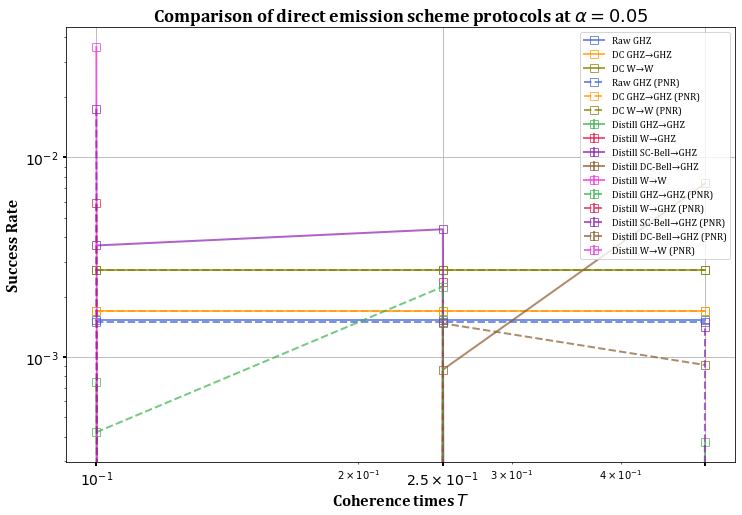

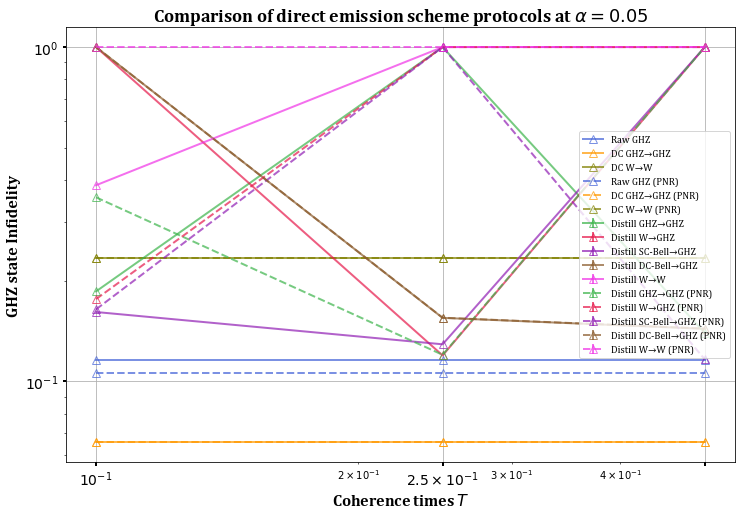

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np
import re

# Load the data from the JSON file
coherence_data = rf"output_data\simulation_data\2025_06_29_21_07_31_data_coherence_times_variation_shots_1_Fprep_0.999_pDE_0.01_mu_0.95_eta_0.4474_alpha_0.05_pg_0.001.json"

with open(coherence_data, "r") as f:
    data = json.load(f)
    
# Extract data from the JSON file

coh_times = np.array(data["coherence_times"])
raw_inf = np.array(data["raw_inf"])
raw_p = np.array(data["raw_p"])
dc_state_inf = np.array(data["dc_state_inf"])
dc_state_p = np.array(data["dc_state_p"])
basic_state_inf = np.array(data["basic_state_inf"])
basic_state_p = np.array(data["basic_state_p"])
basic_state_statistics = data["basic_state_statistics"]
w_state_inf = np.array(data["w_state_inf"])
w_state_p = np.array(data["w_state_p"])
w_state_statistics = data["w_state_statistics"]
bell_sc_distilled_state_inf = np.array(data["bell_sc_distilled_state_inf"])
bell_sc_distilled_state_p = np.array(data["bell_sc_distilled_state_p"])
bell_sc_distilled_state_statistics = data["bell_sc_distilled_state_statistics"]
bell_dc_distilled_state_inf = np.array(data["bell_dc_distilled_state_inf"])
bell_dc_distilled_state_p = np.array(data["bell_dc_distilled_state_p"])
bell_dc_distilled_state_statistics = data["bell_dc_distilled_state_statistics"]
w_to_GHZ_distilled_state_inf = np.array(data["w_to_GHZ_distilled_state_inf"])
w_to_GHZ_distilled_state_p = np.array(data["w_to_GHZ_distilled_state_p"])
w_to_GHZ_distilled_state_statistics = data["w_to_GHZ_distilled_state_statistics"]
w_to_GHZ_dc_state_inf = np.array(data["w_to_GHZ_dc_state_inf"])
w_to_GHZ_dc_state_p = np.array(data["w_to_GHZ_dc_state_p"])
pnr_coh_times = np.array(data["pnr_coherence_times"])
pnr_raw_inf = np.array(data["pnr_raw_inf"])
pnr_raw_p = np.array(data["pnr_raw_p"])
pnr_dc_state_inf = np.array(data["pnr_dc_state_inf"])
pnr_dc_state_p = np.array(data["pnr_dc_state_p"])
pnr_basic_state_inf = np.array(data["pnr_basic_state_inf"])
pnr_basic_state_p = np.array(data["pnr_basic_state_p"])
pnr_basic_state_statistics = data["pnr_basic_state_statistics"]
pnr_w_state_inf = np.array(data["pnr_w_state_inf"])
pnr_w_state_p = np.array(data["pnr_w_state_p"])
pnr_w_state_statistics = data["pnr_w_state_statistics"]
pnr_bell_sc_distilled_state_inf = np.array(data["pnr_bell_sc_distilled_state_inf"])
pnr_bell_sc_distilled_state_p = np.array(data["pnr_bell_sc_distilled_state_p"])
pnr_bell_sc_distilled_state_statistics = data["pnr_bell_sc_distilled_state_statistics"]
pnr_bell_dc_distilled_state_inf = np.array(data["pnr_bell_dc_distilled_state_inf"])
pnr_bell_dc_distilled_state_p = np.array(data["pnr_bell_dc_distilled_state_p"])
pnr_bell_dc_distilled_state_statistics = data["pnr_bell_dc_distilled_state_statistics"]
pnr_w_to_GHZ_distilled_state_inf = np.array(data["pnr_w_to_GHZ_distilled_state_inf"])
pnr_w_to_GHZ_distilled_state_p = np.array(data["pnr_w_to_GHZ_distilled_state_p"])
pnr_w_to_GHZ_distilled_state_statistics = data["pnr_w_to_GHZ_distilled_state_statistics"]
pnr_w_to_GHZ_dc_state_inf = np.array(data["pnr_w_to_GHZ_dc_state_inf"])
pnr_w_to_GHZ_dc_state_p = np.array(data["pnr_w_to_GHZ_dc_state_p"])

# Get shots from the file name
match = re.search(r'shots_(\d+)', coherence_data)
shots = int(match.group(1)) if match else None

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')


ax.plot(coh_times, raw_p, marker='s', color='#4363d8', label='Raw GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel blue
ax.plot(coh_times, dc_state_p, marker='s', color='#ff9900', label='DC GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel orange
ax.errorbar(coh_times, basic_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in basic_state_statistics], marker='s', color='#3cb44b', label='Distill GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel green
ax.errorbar(coh_times, w_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in w_state_statistics], marker='s', color='#e6194b', label='Distill W→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel red
ax.errorbar(coh_times, bell_sc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in bell_sc_distilled_state_statistics], marker='s', color='#911eb4', label='Distill SC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel purple
ax.errorbar(coh_times, bell_dc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in bell_dc_distilled_state_statistics], marker='s', color='#8B5C2D', label='Distill DC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel brown
ax.errorbar(coh_times, w_to_GHZ_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in w_to_GHZ_distilled_state_statistics], marker='s', color='#f032e6', label='Distill W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel pink
ax.plot(coh_times, w_to_GHZ_dc_state_p, marker='s', color='#808000', label='DC W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel olive

ax.plot(pnr_coh_times, pnr_raw_p, marker='s', color='#4363d8', label='Raw GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.plot(pnr_coh_times, pnr_dc_state_p, marker='s', color='#ff9900', label='DC GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(pnr_coh_times, pnr_basic_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_basic_state_statistics], marker='s', color='#3cb44b', label='Distill GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(pnr_coh_times, pnr_w_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_w_state_statistics], marker='s', color='#e6194b', label='Distill W→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(pnr_coh_times, pnr_bell_sc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_bell_sc_distilled_state_statistics], marker='s', color='#911eb4', label='Distill SC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(pnr_coh_times, pnr_bell_dc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_bell_dc_distilled_state_statistics], marker='s', color='#8B5C2D', label='Distill DC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.errorbar(pnr_coh_times, pnr_w_to_GHZ_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_w_to_GHZ_distilled_state_statistics], marker='s', color='#f032e6', label='Distill W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax.plot(pnr_coh_times, pnr_w_to_GHZ_dc_state_p, marker='s', color='#808000', label='DC W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)

# Enable grid
ax.grid(True)

# Set both x-axis and y-axis to log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Set bold axis ticks and labels
ax.set_xticks(coh_times)
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Coherence times $T$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Rate', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
match = re.search(r'alpha_([0-9.]+)', coherence_data)
alpha_val = float(match.group(1))
ax.set_title(rf'Comparison of direct emission scheme protocols at $\alpha={alpha_val}$', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

## INFIDELITY PLOTTING

fig_2, ax_2 = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig_2.patch.set_facecolor('white')
ax_2.set_facecolor('white')

ax_2.plot(coh_times, raw_inf, marker='^', color='#4363d8', label='Raw GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel blue
ax_2.plot(coh_times, dc_state_inf, marker='^', color='#ff9900', label='DC GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel orange
ax_2.errorbar(coh_times, basic_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in basic_state_statistics], marker='^', color='#3cb44b', label='Distill GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel green
ax_2.errorbar(coh_times, w_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in w_state_statistics], marker='^', color='#e6194b', label='Distill W→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel red
ax_2.errorbar(coh_times, bell_sc_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in bell_sc_distilled_state_statistics], marker='^', color='#911eb4', label='Distill SC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel purple
ax_2.errorbar(coh_times, bell_dc_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in bell_dc_distilled_state_statistics], marker='^', color='#8B5C2D', label='Distill DC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel brown
ax_2.errorbar(coh_times, w_to_GHZ_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in w_to_GHZ_distilled_state_statistics], marker='^', color='#f032e6', label='Distill W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel pink
ax_2.plot(coh_times, w_to_GHZ_dc_state_inf, marker='^', color='#808000', label='DC W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel olive

ax_2.plot(pnr_coh_times, pnr_raw_inf, marker='^', color='#4363d8', label='Raw GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.plot(pnr_coh_times, pnr_dc_state_inf, marker='^', color='#ff9900', label='DC GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(pnr_coh_times, pnr_basic_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_basic_state_statistics], marker='^', color='#3cb44b', label='Distill GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(pnr_coh_times, pnr_w_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_w_state_statistics], marker='^', color='#e6194b', label='Distill W→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(pnr_coh_times, pnr_bell_sc_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_bell_sc_distilled_state_statistics], marker='^', color='#911eb4', label='Distill SC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(pnr_coh_times, pnr_bell_dc_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_bell_dc_distilled_state_statistics], marker='^', color='#8B5C2D', label='Distill DC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.errorbar(pnr_coh_times, pnr_w_to_GHZ_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_w_to_GHZ_distilled_state_statistics], marker='^', color='#f032e6', label='Distill W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)
ax_2.plot(pnr_coh_times, pnr_w_to_GHZ_dc_state_inf, marker='^', color='#808000', label='DC W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)

# Enable grid
ax_2.grid(True)

# Set both x-axis and y-axis to log scale
ax_2.set_xscale('log')
ax_2.set_yscale('log')

# Set bold axis ticks and labels
ax_2.set_xticks(coh_times)
ax_2.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax_2.set_xlabel(r'Coherence times $T$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.set_ylabel('GHZ state Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
# Extract alpha from the file name
match = re.search(r'alpha_([0-9.]+)', coherence_data)
alpha_val = float(match.group(1))
ax_2.set_title(rf'Comparison of direct emission scheme protocols at $\alpha={alpha_val}$', fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

# Show the plot
plt.show()

# Save the plots as PDFs
fig.savefig(coherence_data.replace(".json", "_plot_success_rates.pdf").replace("simulation_data","figures"), dpi=300, bbox_inches='tight')
fig_2.savefig(coherence_data.replace(".json", "_plot_infidelity.pdf").replace("simulation_data","figures"), dpi=300, bbox_inches='tight')

## <a id='toc4_4_'></a>[Hardware parameters' improvement](#toc0_)

### <a id='toc4_4_1_'></a>[Data](#toc0_)

Simulation data generation for the hardware parameters' improvement.

In [ ]:
import numpy as np
from circuit_simulation.circuit_simulator import QuantumCircuit
from datetime import datetime

# Get current date and time in the format YYYYMMDDHHMMSS
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

# Coherence times improvement
coh_time = 10

# Operational point for alpha
alpha = 0.05

# Gate error in GHZ generation
pg = 0.001

# Shots
shots = 1

# Bell-state parameters
bell_pair_parameters_list = [{"ent_prot":"single_click","F_prep":0.999,"p_DE":0.01,"mu":0.95,"lambda":1,"eta":0.4474,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.008,"mu":0.96,"lambda":1,"eta":0.62,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":0.999,"p_DE":0.006,"mu":0.97,"lambda":1,"eta":0.8,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":1,"p_DE":0.004,"mu":0.98,"lambda":1,"eta":0.9,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":1,"p_DE":0.0025,"mu":0.99,"lambda":1,"eta":0.95,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":1,"p_DE":0.001,"mu":0.99,"lambda":1,"eta":0.98,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":1,"p_DE":0.0,"mu":1,"lambda":1,"eta":0.99,"alpha":alpha},
                             {"ent_prot":"single_click","F_prep":1,"p_DE":0.0,"mu":1,"lambda":1,"eta":1,"alpha":alpha}]

new_set_hardware = {}

x_positions = range(len(bell_pair_parameters_list))

# Collect data
raw_p = []
raw_inf = []
dc_state_p = []
dc_state_inf = []
basic_state_p = []
basic_state_inf = []
basic_state_statistics = []
w_state_p = []
w_state_inf = []
w_state_statistics = []
bell_sc_distilled_state_p = []
bell_sc_distilled_state_inf = []
bell_sc_distilled_state_statistics = []
bell_dc_distilled_state_p = []
bell_dc_distilled_state_inf = []
bell_dc_distilled_state_statistics = []

w_to_GHZ_distilled_state_p = []
w_to_GHZ_distilled_state_inf = []
w_to_GHZ_distilled_state_statistics = []
w_to_GHZ_dc_state_p = []
w_to_GHZ_dc_state_inf = []

pnr_raw_p = []
pnr_raw_inf = []
pnr_dc_state_p = []
pnr_dc_state_inf = []
pnr_basic_state_p = []
pnr_basic_state_inf = []
pnr_basic_state_statistics = []
pnr_w_state_p = []
pnr_w_state_inf = []
pnr_w_state_statistics = []
pnr_bell_sc_distilled_state_p = []
pnr_bell_sc_distilled_state_inf = []
pnr_bell_sc_distilled_state_statistics = []
pnr_bell_dc_distilled_state_p = []
pnr_bell_dc_distilled_state_inf = []
pnr_bell_dc_distilled_state_statistics = []

pnr_w_to_GHZ_distilled_state_p = []
pnr_w_to_GHZ_distilled_state_inf = []
pnr_w_to_GHZ_distilled_state_statistics = []
pnr_w_to_GHZ_dc_state_p = []
pnr_w_to_GHZ_dc_state_inf = []

for bell_pair_parameter_set in bell_pair_parameters_list:
    print(f"Bell-pair parameters Set-:{bell_pair_parameter_set}")
    raw_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=100, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    raw_p.append(raw_state_qc.p_link)
    raw_inf.append(1-raw_state_qc.F_link)

    dc_bell_pair_parameters = bell_pair_parameter_set.copy()
    dc_bell_pair_parameters["alpha"] = 0.5
    dc_state_qc = QuantumCircuit(0, p_g=pg,network_noise_type=101, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=dc_bell_pair_parameters, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    dc_state_p.append(dc_state_qc.p_link)
    dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=103, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    basic_state_p.append(basic_distilled_state_qc.p_link)
    basic_state_inf.append(1-basic_distilled_state_qc.F_link)
    basic_state_statistics.append(basic_distilled_state_qc.emission_direct_statistics)

    w_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=104, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    w_state_p.append(w_distilled_state_qc.p_link)
    w_state_inf.append(1-w_distilled_state_qc.F_link)
    w_state_statistics.append(w_distilled_state_qc.emission_direct_statistics)

    bell_sc_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)
    bell_sc_distilled_state_statistics.append(bell_sc_distilled_state_qc.emission_direct_statistics)

    bell_dc_pair_parameters = bell_pair_parameter_set.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)
    bell_dc_distilled_state_statistics.append(bell_dc_distilled_state_qc.emission_direct_statistics)

    w_to_GHZ_distilled_state_qc = QuantumCircuit(0, p_g=pg, network_noise_type=107, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameter_set, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    w_to_GHZ_distilled_state_p.append(w_to_GHZ_distilled_state_qc.p_link)
    w_to_GHZ_distilled_state_inf.append(1-w_to_GHZ_distilled_state_qc.F_link)
    w_to_GHZ_distilled_state_statistics.append(w_to_GHZ_distilled_state_qc.emission_direct_statistics)

    w_to_GHZ_dc_state_qc = QuantumCircuit(0, p_g=pg, network_noise_type=106, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=bell_pair_parameter_set, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    w_to_GHZ_dc_state_p.append(w_to_GHZ_dc_state_qc.p_link)
    w_to_GHZ_dc_state_inf.append(1-w_to_GHZ_dc_state_qc.F_link)

for bell_pair_parameter_set in bell_pair_parameters_list:
    print(f"Bell-pair parameters Set-:{bell_pair_parameter_set}")
    raw_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=100, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_raw_p.append(raw_state_qc.p_link)
    pnr_raw_inf.append(1-raw_state_qc.F_link)

    dc_bell_pair_parameters = bell_pair_parameter_set.copy()
    dc_bell_pair_parameters["alpha"] = 0.5
    dc_state_qc = QuantumCircuit(0, p_g=pg,network_noise_type=101, only_GHZ=True, shots_emission_direct=shots, bell_pair_parameters=dc_bell_pair_parameters, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    pnr_dc_state_p.append(dc_state_qc.p_link)
    pnr_dc_state_inf.append(1-dc_state_qc.F_link)

    basic_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=103, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_basic_state_p.append(basic_distilled_state_qc.p_link)
    pnr_basic_state_inf.append(1-basic_distilled_state_qc.F_link)
    pnr_basic_state_statistics.append(basic_distilled_state_qc.emission_direct_statistics)

    w_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=104, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_w_state_p.append(w_distilled_state_qc.p_link)
    pnr_w_state_inf.append(1-w_distilled_state_qc.F_link)
    pnr_w_state_statistics.append(w_distilled_state_qc.emission_direct_statistics)

    bell_sc_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True,bell_pair_parameters=bell_pair_parameter_set,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_sc_distilled_state_p.append(bell_sc_distilled_state_qc.p_link)
    pnr_bell_sc_distilled_state_inf.append(1-bell_sc_distilled_state_qc.F_link)
    pnr_bell_sc_distilled_state_statistics.append(bell_sc_distilled_state_qc.emission_direct_statistics)

    bell_dc_pair_parameters = bell_pair_parameter_set.copy()
    bell_dc_pair_parameters["ent_prot"] = "double_click"
    bell_dc_distilled_state_qc = QuantumCircuit(0,p_g=pg,network_noise_type=102, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True,bell_pair_parameters=bell_dc_pair_parameters,T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
    pnr_bell_dc_distilled_state_p.append(bell_dc_distilled_state_qc.p_link)
    pnr_bell_dc_distilled_state_inf.append(1-bell_dc_distilled_state_qc.F_link)
    pnr_bell_dc_distilled_state_statistics.append(bell_dc_distilled_state_qc.emission_direct_statistics)

    w_to_GHZ_distilled_state_qc = QuantumCircuit(0, p_g=pg, network_noise_type=107, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameter_set, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    pnr_w_to_GHZ_distilled_state_p.append(w_to_GHZ_distilled_state_qc.p_link)
    pnr_w_to_GHZ_distilled_state_inf.append(1-w_to_GHZ_distilled_state_qc.F_link)
    pnr_w_to_GHZ_distilled_state_statistics.append(w_to_GHZ_distilled_state_qc.emission_direct_statistics)

    w_to_GHZ_dc_state_qc = QuantumCircuit(0, p_g=pg, network_noise_type=106, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=True, bell_pair_parameters=bell_pair_parameter_set, T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time, T2e_idle=coh_time, T1e_idle=coh_time)
    pnr_w_to_GHZ_dc_state_p.append(w_to_GHZ_dc_state_qc.p_link)
    pnr_w_to_GHZ_dc_state_inf.append(1-w_to_GHZ_dc_state_qc.F_link)

# Filter out nan values
valid_indices = ~np.isnan(raw_inf) & ~np.isnan(dc_state_inf) & ~np.isnan(basic_state_inf) & ~np.isnan(w_state_inf) & ~np.isnan(bell_sc_distilled_state_inf) & ~np.isnan(bell_dc_distilled_state_inf)
x_positions_array = np.array(x_positions)  # Convert x_positions to a NumPy array
x_positions_filtered = x_positions_array[valid_indices]
raw_inf_filtered = np.array(raw_inf)[valid_indices]
raw_p_filtered = np.array(raw_p)[valid_indices]
dc_state_inf_filtered = np.array(dc_state_inf)[valid_indices]
dc_state_p_filtered = np.array(dc_state_p)[valid_indices]
basic_state_inf_filtered = np.array(basic_state_inf)[valid_indices]
basic_state_p_filtered = np.array(basic_state_p)[valid_indices]
basic_state_statistics_filtered = np.array(basic_state_statistics)[valid_indices]
w_state_inf_filtered = np.array(w_state_inf)[valid_indices]
w_state_p_filtered = np.array(w_state_p)[valid_indices]
w_state_statistics_filtered = np.array(w_state_statistics)[valid_indices]
bell_sc_distilled_state_inf_filtered = np.array(bell_sc_distilled_state_inf)[valid_indices]
bell_sc_distilled_state_p_filtered = np.array(bell_sc_distilled_state_p)[valid_indices]
bell_sc_distilled_state_statistics_filtered = np.array(bell_sc_distilled_state_statistics)[valid_indices]
bell_dc_distilled_state_inf_filtered = np.array(bell_dc_distilled_state_inf)[valid_indices]
bell_dc_distilled_state_p_filtered = np.array(bell_dc_distilled_state_p)[valid_indices]
bell_dc_distilled_state_statistics_filtered = np.array(bell_dc_distilled_state_statistics)[valid_indices]
w_to_GHZ_distilled_state_inf_filtered = np.array(w_to_GHZ_distilled_state_inf)[valid_indices]
w_to_GHZ_distilled_state_p_filtered = np.array(w_to_GHZ_distilled_state_p)[valid_indices]
w_to_GHZ_distilled_state_statistics_filtered = np.array(w_to_GHZ_distilled_state_statistics)[valid_indices]
w_to_GHZ_dc_state_inf_filtered = np.array(w_to_GHZ_dc_state_inf)[valid_indices]
w_to_GHZ_dc_state_p_filtered = np.array(w_to_GHZ_dc_state_p)[valid_indices]

valid_indices_pnr = ~np.isnan(pnr_raw_inf) & ~np.isnan(pnr_dc_state_inf) & ~np.isnan(pnr_basic_state_inf) & ~np.isnan(pnr_w_state_inf) & ~np.isnan(pnr_bell_sc_distilled_state_inf) & ~np.isnan(pnr_bell_dc_distilled_state_inf)
x_positions_filtered_pnr = x_positions_array[valid_indices_pnr]
pnr_raw_inf_filtered = np.array(pnr_raw_inf)[valid_indices_pnr]
pnr_raw_p_filtered = np.array(pnr_raw_p)[valid_indices_pnr]
pnr_dc_state_p_filtered = np.array(pnr_dc_state_p)[valid_indices_pnr]
pnr_dc_state_inf_filtered = np.array(pnr_dc_state_inf)[valid_indices_pnr]
pnr_basic_state_p_filtered = np.array(pnr_basic_state_p)[valid_indices_pnr]
pnr_basic_state_inf_filtered = np.array(pnr_basic_state_inf)[valid_indices_pnr]
pnr_basic_state_statistics_filtered = np.array(pnr_basic_state_statistics)[valid_indices_pnr]
pnr_w_state_inf_filtered = np.array(pnr_w_state_inf)[valid_indices_pnr]
pnr_w_state_p_filtered = np.array(pnr_w_state_p)[valid_indices_pnr]
pnr_w_state_statistics_filtered = np.array(pnr_w_state_statistics)[valid_indices_pnr]
pnr_bell_sc_distilled_state_inf_filtered = np.array(pnr_bell_sc_distilled_state_inf)[valid_indices_pnr]
pnr_bell_sc_distilled_state_p_filtered = np.array(pnr_bell_sc_distilled_state_p)[valid_indices_pnr]
pnr_bell_sc_distilled_state_statistics_filtered = np.array(pnr_bell_sc_distilled_state_statistics)[valid_indices_pnr]
pnr_bell_dc_distilled_state_inf_filtered = np.array(pnr_bell_dc_distilled_state_inf)[valid_indices_pnr]
pnr_bell_dc_distilled_state_p_filtered = np.array(pnr_bell_dc_distilled_state_p)[valid_indices_pnr]
pnr_bell_dc_distilled_state_statistics_filtered = np.array(pnr_bell_dc_distilled_state_statistics)[valid_indices_pnr]
pnr_w_to_GHZ_distilled_state_inf_filtered = np.array(pnr_w_to_GHZ_distilled_state_inf)[valid_indices_pnr]
pnr_w_to_GHZ_distilled_state_p_filtered = np.array(pnr_w_to_GHZ_distilled_state_p)[valid_indices_pnr]
pnr_w_to_GHZ_distilled_state_statistics_filtered = np.array(pnr_w_to_GHZ_distilled_state_statistics)[valid_indices_pnr]
pnr_w_to_GHZ_dc_state_inf_filtered = np.array(pnr_w_to_GHZ_dc_state_inf)[valid_indices_pnr]
pnr_w_to_GHZ_dc_state_p_filtered = np.array(pnr_w_to_GHZ_dc_state_p)[valid_indices_pnr]

# Save the results to a JSON file for later plotting
import json
results_dict = {
    "x_positions": x_positions_filtered.tolist(),
    "raw_inf": raw_inf_filtered.tolist(),
    "raw_p": raw_p_filtered.tolist(),
    "dc_state_inf": dc_state_inf_filtered.tolist(),
    "dc_state_p": dc_state_p_filtered.tolist(),
    "basic_state_inf": basic_state_inf_filtered.tolist(),
    "basic_state_p": basic_state_p_filtered.tolist(),
    "basic_state_statistics": basic_state_statistics_filtered.tolist(),
    "w_state_inf": w_state_inf_filtered.tolist(),
    "w_state_p": w_state_p_filtered.tolist(),
    "w_state_statistics": w_state_statistics_filtered.tolist(),
    "bell_sc_distilled_state_inf": bell_sc_distilled_state_inf_filtered.tolist(),
    "bell_sc_distilled_state_p": bell_sc_distilled_state_p_filtered.tolist(),
    "bell_sc_distilled_state_statistics": bell_sc_distilled_state_statistics_filtered.tolist(),
    "bell_dc_distilled_state_inf": bell_dc_distilled_state_inf_filtered.tolist(),
    "bell_dc_distilled_state_p": bell_dc_distilled_state_p_filtered.tolist(),
    "bell_dc_distilled_state_statistics": bell_dc_distilled_state_statistics_filtered.tolist(),
    "w_to_GHZ_distilled_state_inf": w_to_GHZ_distilled_state_inf_filtered.tolist(),
    "w_to_GHZ_distilled_state_p": w_to_GHZ_distilled_state_p_filtered.tolist(),
    "w_to_GHZ_distilled_state_statistics": w_to_GHZ_distilled_state_statistics_filtered.tolist(),
    "w_to_GHZ_dc_state_inf": w_to_GHZ_dc_state_inf_filtered.tolist(),
    "w_to_GHZ_dc_state_p": w_to_GHZ_dc_state_p_filtered.tolist(),
    "x_positions_pnr": x_positions_filtered_pnr.tolist(),
    "pnr_raw_inf": pnr_raw_inf_filtered.tolist(),
    "pnr_raw_p": pnr_raw_p_filtered.tolist(),
    "pnr_dc_state_inf": pnr_dc_state_inf_filtered.tolist(),
    "pnr_dc_state_p": pnr_dc_state_p_filtered.tolist(),
    "pnr_basic_state_inf": pnr_basic_state_inf_filtered.tolist(),
    "pnr_basic_state_p": pnr_basic_state_p_filtered.tolist(),
    "pnr_basic_state_statistics": pnr_basic_state_statistics_filtered.tolist(),
    "pnr_w_state_inf": pnr_w_state_inf_filtered.tolist(),
    "pnr_w_state_p": pnr_w_state_p_filtered.tolist(),
    "pnr_w_state_statistics": pnr_w_state_statistics_filtered.tolist(),
    "pnr_bell_sc_distilled_state_inf": pnr_bell_sc_distilled_state_inf_filtered.tolist(),
    "pnr_bell_sc_distilled_state_p": pnr_bell_sc_distilled_state_p_filtered.tolist(),
    "pnr_bell_sc_distilled_state_statistics": pnr_bell_sc_distilled_state_statistics_filtered.tolist(),
    "pnr_bell_dc_distilled_state_inf": pnr_bell_dc_distilled_state_inf_filtered.tolist(),
    "pnr_bell_dc_distilled_state_p": pnr_bell_dc_distilled_state_p_filtered.tolist(),
    "pnr_bell_dc_distilled_state_statistics": pnr_bell_dc_distilled_state_statistics_filtered.tolist(),
    "pnr_w_to_GHZ_distilled_state_inf": pnr_w_to_GHZ_distilled_state_inf_filtered.tolist(),
    "pnr_w_to_GHZ_distilled_state_p": pnr_w_to_GHZ_distilled_state_p_filtered.tolist(),
    "pnr_w_to_GHZ_distilled_state_statistics": pnr_w_to_GHZ_distilled_state_statistics_filtered.tolist(),
    "pnr_w_to_GHZ_dc_state_inf": pnr_w_to_GHZ_dc_state_inf_filtered.tolist(),
    "pnr_w_to_GHZ_dc_state_p": pnr_w_to_GHZ_dc_state_p_filtered.tolist(),
}

hardware_parameters_data = rf'.\output_data\simulation_data\{timestamp}_data_hardware_parameters_improvement_success_rates_shots_{shots}_alpha_{alpha}_cohtime_{coh_time}_pg_{pg}.json'
with open(hardware_parameters_data, 'w') as f:
    json.dump(results_dict, f, indent=4)


### <a id='toc4_4_2_'></a>[Plot](#toc0_)

Plotter for the data generated for the hardware parameters' improvement.

c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\ssingh8\Anaconda3\envs\super_env\lib\site-packages\numpy\core\_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
c:\Users\ssi

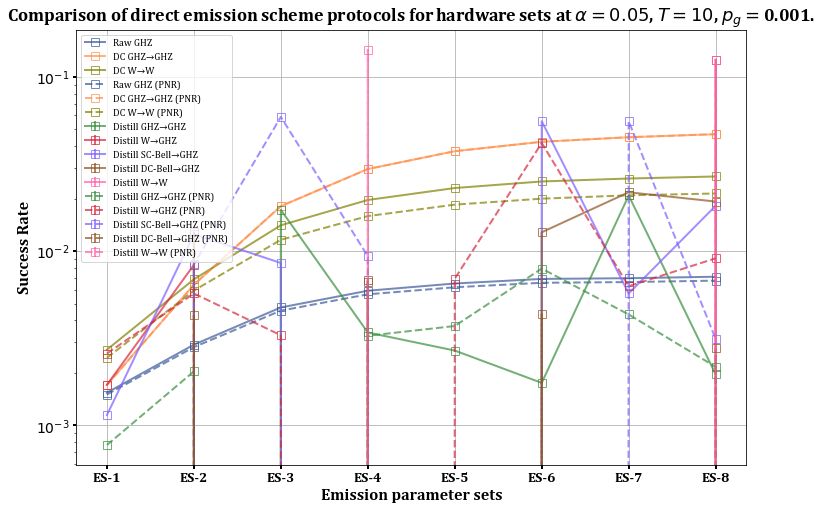

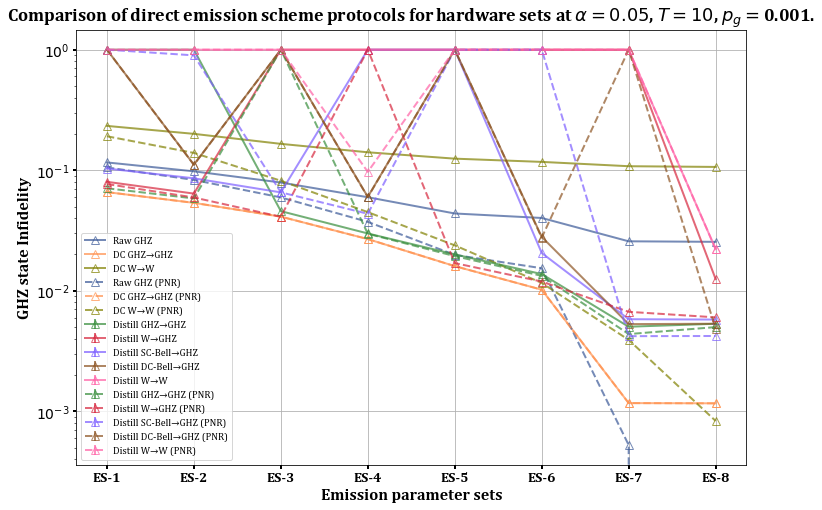

In [14]:
import matplotlib.pyplot as plt
import json
import re
import numpy as np

# Load the results from the JSON file
hardware_parameters_data = rf"output_data\simulation_data\2025_06_29_21_14_14_data_hardware_parameters_improvement_success_rates_shots_1_alpha_0.05_cohtime_10_pg_0.001.json"
with open(hardware_parameters_data, "r") as json_file:
    results_dict = json.load(json_file)

# Extract the data from the loaded dictionary
x_positions = results_dict["x_positions"]
raw_p = results_dict["raw_p"]
raw_inf = results_dict["raw_inf"]
dc_state_p = results_dict["dc_state_p"]
dc_state_inf = results_dict["dc_state_inf"]
basic_state_p = results_dict["basic_state_p"]
basic_state_inf = results_dict["basic_state_inf"]
basic_state_statistics = results_dict["basic_state_statistics"]
w_state_p = results_dict["w_state_p"]
w_state_inf = results_dict["w_state_inf"]
w_state_statistics = results_dict["w_state_statistics"]
bell_sc_distilled_state_p = results_dict["bell_sc_distilled_state_p"]
bell_sc_distilled_state_inf = results_dict["bell_sc_distilled_state_inf"]
bell_sc_distilled_state_statistics = results_dict["bell_sc_distilled_state_statistics"]
bell_dc_distilled_state_p = results_dict["bell_dc_distilled_state_p"]
bell_dc_distilled_state_inf = results_dict["bell_dc_distilled_state_inf"]
bell_dc_distilled_state_statistics = results_dict["bell_dc_distilled_state_statistics"]
w_to_GHZ_distilled_state_p = results_dict["w_to_GHZ_distilled_state_p"]
w_to_GHZ_distilled_state_inf = results_dict["w_to_GHZ_distilled_state_inf"]
w_to_GHZ_distilled_state_statistics = results_dict["w_to_GHZ_distilled_state_statistics"]
w_to_GHZ_dc_state_p = results_dict["w_to_GHZ_dc_state_p"]
w_to_GHZ_dc_state_inf = results_dict["w_to_GHZ_dc_state_inf"]

pnr_x_positions = results_dict["x_positions_pnr"]
pnr_raw_p = results_dict["pnr_raw_p"]
pnr_raw_inf = results_dict["pnr_raw_inf"]
pnr_dc_state_p = results_dict["pnr_dc_state_p"]
pnr_dc_state_inf = results_dict["pnr_dc_state_inf"]
pnr_basic_state_p = results_dict["pnr_basic_state_p"]
pnr_basic_state_inf = results_dict["pnr_basic_state_inf"]
pnr_basic_state_statistics = results_dict["pnr_basic_state_statistics"]
pnr_w_state_p = results_dict["pnr_w_state_p"]
pnr_w_state_inf = results_dict["pnr_w_state_inf"]
pnr_w_state_statistics = results_dict["pnr_w_state_statistics"]
pnr_bell_sc_distilled_state_p = results_dict["pnr_bell_sc_distilled_state_p"]
pnr_bell_sc_distilled_state_inf = results_dict["pnr_bell_sc_distilled_state_inf"]
pnr_bell_sc_distilled_state_statistics = results_dict["pnr_bell_sc_distilled_state_statistics"]
pnr_bell_dc_distilled_state_p = results_dict["pnr_bell_dc_distilled_state_p"]
pnr_bell_dc_distilled_state_inf = results_dict["pnr_bell_dc_distilled_state_inf"]
pnr_bell_dc_distilled_state_statistics = results_dict["pnr_bell_dc_distilled_state_statistics"]
pnr_w_to_GHZ_distilled_state_p = results_dict["pnr_w_to_GHZ_distilled_state_p"]
pnr_w_to_GHZ_distilled_state_inf = results_dict["pnr_w_to_GHZ_distilled_state_inf"]
pnr_w_to_GHZ_distilled_state_statistics = results_dict["pnr_w_to_GHZ_distilled_state_statistics"]
pnr_w_to_GHZ_dc_state_p = results_dict["pnr_w_to_GHZ_dc_state_p"]
pnr_w_to_GHZ_dc_state_inf = results_dict["pnr_w_to_GHZ_dc_state_inf"]

# Find shots from the file name
match_shots = re.search(r'shots_(\d+)', hardware_parameters_data)
shots = int(match_shots.group(1))

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Plot the curves with specified markers and colors
ax.plot(x_positions, raw_p, marker='s', color='#3B5998', label='Raw GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Blue
ax.plot(x_positions, dc_state_p, marker='s', color='#FF914D', label='DC GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Orange
ax.errorbar(x_positions, basic_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in basic_state_statistics], marker='s', color='#388E3C', label='Distill GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Green
ax.errorbar(x_positions, w_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in w_state_statistics], marker='s', color='#D7263D', label='Distill W→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Red
ax.errorbar(x_positions, bell_sc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in bell_sc_distilled_state_statistics], marker='s', color='#7D5FFF', label='Distill SC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Purple
ax.errorbar(x_positions, bell_dc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in bell_dc_distilled_state_statistics], marker='s', color='#8D5524', label='Distill DC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Brown
ax.errorbar(x_positions, w_to_GHZ_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in w_to_GHZ_distilled_state_statistics], marker='s', color='#FF61A6', label='Distill W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Pink
ax.plot(x_positions, w_to_GHZ_dc_state_p, marker='s', color='#808000', label='DC W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Olive

ax.plot(pnr_x_positions, pnr_raw_p, marker='s', color='#3B5998', label='Raw GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Blue
ax.plot(pnr_x_positions, pnr_dc_state_p, marker='s', color='#FF914D', label='DC GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Orange
ax.errorbar(pnr_x_positions, pnr_basic_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_basic_state_statistics], marker='s', color='#388E3C', label='Distill GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Green
ax.errorbar(pnr_x_positions, pnr_w_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_w_state_statistics], marker='s', color='#D7263D', label='Distill W→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Red
ax.errorbar(pnr_x_positions, pnr_bell_sc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_bell_sc_distilled_state_statistics], marker='s', color='#7D5FFF', label='Distill SC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Purple
ax.errorbar(pnr_x_positions, pnr_bell_dc_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_bell_dc_distilled_state_statistics], marker='s', color='#8D5524', label='Distill DC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Brown
ax.errorbar(pnr_x_positions, pnr_w_to_GHZ_distilled_state_p, yerr=[np.std(np.array(i["p_link"]))/np.sqrt(shots) for i in pnr_w_to_GHZ_distilled_state_statistics], marker='s', color='#FF61A6', label='Distill W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Pink
ax.plot(pnr_x_positions, pnr_w_to_GHZ_dc_state_p, marker='s', color='#808000', label='DC W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Olive

# Enable grid
ax.grid(True)

# Set y-axis to log scale
# ax.set_xscale('log')
ax.set_yscale('log')

# Set bold axis ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels([f'ES-{i+1}' for i in x_positions], fontsize=12, fontweight='bold', fontdict={'family': 'Cambria'})
ax.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax.set_xlabel(r'Emission parameter sets', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax.set_ylabel('Success Rate', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
# Extract alpha, coh_time, and pg from the file name for the title

match_alpha = re.search(r'alpha_([0-9.]+)', hardware_parameters_data)
match_cohtime = re.search(r'cohtime_([0-9.]+)', hardware_parameters_data)
match_pg = re.search(r'pg_([0-9.]+)', hardware_parameters_data)

alpha_str = match_alpha.group(1) if match_alpha else "?"
coh_time_str = match_cohtime.group(1) if match_cohtime else "?"
pg_str = match_pg.group(1) if match_pg else "?"

ax.set_title(
    rf'Comparison of direct emission scheme protocols for hardware sets at $\alpha={alpha_str}$, $T={coh_time_str}$, $p_g=${pg_str}',
    fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'}
)
ax.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

## INFIDELITY PLOTTING

fig_2, ax_2 = plt.subplots(figsize=(12, 8))

# Set the background color to white
fig_2.patch.set_facecolor('white')
ax_2.set_facecolor('white')

ax_2.plot(x_positions, raw_inf, marker='^', color='#3B5998', label='Raw GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Blue
ax_2.plot(x_positions, dc_state_inf, marker='^', color='#FF914D', label='DC GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Orange
ax_2.errorbar(x_positions, basic_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in basic_state_statistics], marker='^', color='#388E3C', label='Distill GHZ→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Green
ax_2.errorbar(x_positions, w_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in w_state_statistics], marker='^', color='#D7263D', label='Distill W→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Red
ax_2.errorbar(x_positions, bell_sc_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in bell_sc_distilled_state_statistics], marker='^', color='#7D5FFF', label='Distill SC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Purple
ax_2.errorbar(x_positions, bell_dc_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in bell_dc_distilled_state_statistics], marker='^', color='#8D5524', label='Distill DC-Bell→GHZ', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Brown
ax_2.errorbar(x_positions, w_to_GHZ_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in w_to_GHZ_distilled_state_statistics], marker='^', color='#FF61A6', label='Distill W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Pink
ax_2.plot(x_positions, w_to_GHZ_dc_state_inf, marker='^', color='#808000', label='DC W→W', linestyle='-', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Olive

ax_2.plot(pnr_x_positions, pnr_raw_inf, marker='^', color='#3B5998', label='Raw GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Blue
ax_2.plot(pnr_x_positions, pnr_dc_state_inf, marker='^', color='#FF914D', label='DC GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Orange
ax_2.errorbar(pnr_x_positions, pnr_basic_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_basic_state_statistics], marker='^', color='#388E3C', label='Distill GHZ→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Green
ax_2.errorbar(pnr_x_positions, pnr_w_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_w_state_statistics], marker='^', color='#D7263D', label='Distill W→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Red
ax_2.errorbar(pnr_x_positions, pnr_bell_sc_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_bell_sc_distilled_state_statistics], marker='^', color='#7D5FFF', label='Distill SC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Purple
ax_2.errorbar(pnr_x_positions, pnr_bell_dc_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_bell_dc_distilled_state_statistics], marker='^', color='#8D5524', label='Distill DC-Bell→GHZ (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Brown
ax_2.errorbar(pnr_x_positions, pnr_w_to_GHZ_distilled_state_inf, yerr=[np.std(1-np.array(i["F_link"]))/np.sqrt(shots) for i in pnr_w_to_GHZ_distilled_state_statistics], marker='^', color='#FF61A6', label='Distill W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Dark pastel Pink
ax_2.plot(pnr_x_positions, pnr_w_to_GHZ_dc_state_inf, marker='^', color='#808000', label='DC W→W (PNR)', linestyle='--', linewidth=2, markersize=8, markerfacecolor='none', alpha=0.7)  # Olive

# Enable grid
ax_2.grid(True)

# Set y-axis to log scale
# ax_2.set_xscale('log')
ax_2.set_yscale('log')

# Set bold axis ticks and labels
ax_2.set_xticks(x_positions)
ax_2.set_xticklabels([f'ES-{i+1}' for i in x_positions], fontsize=12, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.tick_params(axis='both', which='major', labelsize=14, labelcolor='black', width=2)
ax_2.set_xlabel(r'Emission parameter sets', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
ax_2.set_ylabel('GHZ state Infidelity', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})

# Set title and legend
ax_2.set_title(
    rf'Comparison of direct emission scheme protocols for hardware sets at $\alpha={alpha_str}$, $T={coh_time_str}$, $p_g=${pg_str}',
    fontsize=18, fontweight='bold', fontdict={'family': 'Cambria'}
)
ax_2.legend(fontsize=16, prop={'family': 'Cambria'})  # Increased fontsize

# Show the plot
plt.show()

# Save the plots as PDFs
fig.savefig(hardware_parameters_data.replace(".json", "_plot_success_rates.pdf").replace("simulation_data","figures"), dpi=300, bbox_inches='tight')
fig_2.savefig(hardware_parameters_data.replace(".json", "_plot_infidelity.pdf").replace("simulation_data","figures"), dpi=300, bbox_inches='tight')

## <a id='toc4_5_'></a>[Heatmaps for hardware and coherence parameters for the performance](#toc0_)

### <a id='toc4_5_1_'></a>[Data](#toc0_)

Simulation data generation for the heatmaps for hardware and coherence parameters for the performance.

In [ ]:
import numpy as np
from circuit_simulation.circuit_simulator import QuantumCircuit
import matplotlib.pyplot as plt
import json
from datetime import datetime

# Get current date and time in the format YYYYMMDDHHMMSS
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

#Shots
shots = 2

# Photon number resolution
pnr = False

# Bright state parameter alpha
alpha = 0.05

# Gate error in GHZ state
pg = 0.001

# Define the coherence times and Bell pair parameter sets
coh_times = [0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100]

bell_pair_parameters_list = [
    {"ent_prot": "single_click", "F_prep": 0.999, "p_DE": 0.01, "mu": 0.95, "lambda": 1, "eta": 0.4474, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 0.999, "p_DE": 0.008, "mu": 0.96, "lambda": 1, "eta": 0.62, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 0.999, "p_DE": 0.006, "mu": 0.97, "lambda": 1, "eta": 0.8, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 1, "p_DE": 0.004, "mu": 0.98, "lambda": 1, "eta": 0.9, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 1, "p_DE": 0.002, "mu": 0.99, "lambda": 1, "eta": 0.95, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 1, "p_DE": 0.001, "mu": 0.99, "lambda": 1, "eta": 0.98, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 1, "p_DE": 0.0, "mu": 1, "lambda": 1, "eta": 0.99, "alpha": alpha},
    {"ent_prot": "single_click", "F_prep": 1, "p_DE": 0.0, "mu": 1, "lambda": 1, "eta": 1, "alpha": alpha}
]

# Initialize matrices to store infidelity and success probability values for each protocol
protocols = ["Direct Raw", "Direct DC", "Distill Basic", "Distill W", "Distill SC Bell", "Distill DC Bell", "Distill W to GHZ", "W to GHZ DC"]
infidelity_data = {protocol: np.zeros((len(coh_times), len(bell_pair_parameters_list))) for protocol in protocols}
success_rate_data = {protocol: np.zeros((len(coh_times), len(bell_pair_parameters_list))) for protocol in protocols}
statistics_data = {protocol: [[[] for _ in range(len(bell_pair_parameters_list))] for _ in range(len(coh_times))] for protocol in protocols}

# Loop over the coherence times, Bell pair parameter sets, and protocols
for i, coh_time in enumerate(coh_times):
    for j, bell_pair_parameters in enumerate(bell_pair_parameters_list):
        for protocol in protocols:
            # Set alpha=0.5 only for the "Direct DC" protocol
            if protocol == "Direct DC":
                bell_pair_parameters["alpha"] = 0.5
            elif protocol != "Direct DC":
                bell_pair_parameters["alpha"] = alpha
            if protocol == "Distill DC Bell":
                bell_pair_parameters["ent_prot"] = "double_click"
            elif protocol != "Distill DC Bell":
                bell_pair_parameters["ent_prot"] = "single_click"
            print(f"Coherence time: {coh_time}, Bell pair parameters: {bell_pair_parameters}, Protocol: {protocol}")
            network_noise_type = {
                "Direct Raw": 100,
                "Direct DC": 101,
                "Distill Basic": 103,
                "Distill W": 104,
                "Distill SC Bell": 102,
                "Distill DC Bell": 102,
                "Distill W to GHZ": 107,
                "W to GHZ DC": 106
            }[protocol]
            qc = QuantumCircuit(0, p_g=pg,network_noise_type=network_noise_type, only_GHZ=True, shots_emission_direct=shots, photon_number_resolution=pnr, bell_pair_parameters=bell_pair_parameters,
                                T2n_idle=coh_time, T1n_idle=coh_time, T2n_link=coh_time, T1n_link=coh_time,
                                T2e_idle=coh_time, T1e_idle=coh_time)
            infidelity_data[protocol][i, j] = 1 - qc.F_link
            success_rate_data[protocol][i, j] = qc.p_link
            statistics_data[protocol][i][j] = qc.emission_direct_statistics

# Save the results to a JSON file for later plotting
results_dict = {
    "coh_times": coh_times,
    "bell_pair_parameters_list": bell_pair_parameters_list,
    "protocols": protocols,
    "infidelity_data": {k: v.tolist() for k, v in infidelity_data.items()},
    "success_rate_data": {k: v.tolist() for k, v in success_rate_data.items()},
    "statistics_data": {k: v for k, v in statistics_data.items()}
}
heatmap_data_file = rf'.\output_data\simulation_data\{timestamp}_heatmap_hardware_coherence_parameters_shots_{shots}_pnr_{pnr}_alpha_{alpha}_pg_{pg}.json'
with open(heatmap_data_file, 'w') as f:
    json.dump(results_dict, f, indent=2)

### <a id='toc4_5_2_'></a>[Plot](#toc0_)

Plotter for the data generated for the heatmaps for hardware and coherence parameters for the performance.

In [ ]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Load the data from the JSON file
heatmap_data_file = rf"output_data\simulation_data\2025_06_29_21_21_11_heatmap_hardware_coherence_parameters_shots_2_alpha_0.05_pg_0.001.json"
with open(heatmap_data_file, "r") as json_file:
    results_dict = json.load(json_file)

# Extract the data from the loaded dictionary
coh_times = np.array(results_dict["coh_times"])
bell_pair_parameters_list = results_dict["bell_pair_parameters_list"]
protocols = results_dict["protocols"]
infidelity_data = {k: np.array(v) for k, v in results_dict["infidelity_data"].items()}
success_rate_data = {k: np.array(v) for k, v in results_dict["success_rate_data"].items()}
statistics_data = {k: np.array(v) for k, v in results_dict["statistics_data"].items()}

# Find shots from the file name
match_shots = re.search(r'shots_(\d+)', heatmap_data_file)
shots = int(match_shots.group(1))

# Reverse the coherence times for proper ordering
reversed_coh_times = coh_times[::-1]

# Plot and save heatmaps for infidelity and success rate for each protocol separately
for idx, protocol in enumerate(protocols):
    # Infidelity heatmap
    fig_inf, ax_inf = plt.subplots(figsize=(8, 6))
    ax_inf.set_facecolor('white')
    im_inf = ax_inf.imshow(infidelity_data[protocol][::-1], aspect='auto', cmap='viridis')
    ax_inf.set_title(f'{protocol} Infidelity', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 18})
    ax_inf.set_xlabel('Emission Parameter Sets', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 14})
    ax_inf.set_ylabel('Coherence Times', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 14})
    ax_inf.tick_params(axis='both', which='major', labelsize=12, labelcolor='black')
    ax_inf.set_xticks(range(len(bell_pair_parameters_list)))
    ax_inf.set_xticklabels([f'ES-{i+1}' for i in range(len(bell_pair_parameters_list))], rotation=45)
    ax_inf.set_yticks(range(len(reversed_coh_times)))
    ax_inf.set_yticklabels(reversed_coh_times)
    fig_inf.colorbar(im_inf, ax=ax_inf)
    # Shade region where infidelity <= 1e-2
    ax_inf.contourf(
        infidelity_data[protocol][::-1],
        levels=[0, 1e-2],
        hatches=['///'],
        colors='red',
        alpha=0
    )

    fig_inf.savefig(heatmap_data_file.replace(".json", f"_{protocol.replace(' ', '_').lower()}_infidelity_heatmap.pdf").replace("simulation_data", "figures"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig_inf)

    # Success rate heatmap
    fig_succ, ax_succ = plt.subplots(figsize=(8, 6))
    ax_succ.set_facecolor('white')
    im_succ = ax_succ.imshow(success_rate_data[protocol][::-1], aspect='auto', cmap='viridis')
    ax_succ.set_title(f'{protocol} Success Rate', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 18})
    ax_succ.set_xlabel('Emission Parameter Sets', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 14})
    ax_succ.set_ylabel('Coherence Times', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 14})
    ax_succ.tick_params(axis='both', which='major', labelsize=12, labelcolor='black')
    ax_succ.set_xticks(range(len(bell_pair_parameters_list)))
    ax_succ.set_xticklabels([f'ES-{i+1}' for i in range(len(bell_pair_parameters_list))], rotation=45)
    ax_succ.set_yticks(range(len(reversed_coh_times)))
    ax_succ.set_yticklabels(reversed_coh_times)
    fig_succ.colorbar(im_succ, ax=ax_succ)
    # Shade region where success rate >= 1e-3
    ax_succ.contourf(
        success_rate_data[protocol][::-1],
        levels=[1e-3, success_rate_data[protocol].max()],
        hatches=['///'],
        colors='red',
        alpha=0
    )
    fig_succ.savefig(heatmap_data_file.replace(".json", f"_{protocol.replace(' ', '_').lower()}_success_rates_heatmap.pdf").replace("simulation_data", "figures"), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig_succ)

## <a id='toc4_6_'></a>[Heatmaps for bright state parameters for raw and distillation resource](#toc0_)

### <a id='toc4_6_1_'></a>[Data](#toc0_)

Simulation data generation for the bright state parameter influence for the raw and distillation resource.

In [17]:
import numpy as np
from circuit_simulation.circuit_simulator import QuantumCircuit
import json
from datetime import datetime
# Get current date and time in the format YYYYMMDDHHMMSS
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

# Shots
shots = 1

# Photon number resolution
pnr = True

# Coherence times
coh_time = 10  # Coherence times

# Gate error in GHZ state preparation
pg = 0.001

# Define the range for alpha and alpha_distill for infidelity
alpha_range = np.arange(0.05, 0.525, 0.125)
alpha_distill_range = np.arange(0.05, 0.525, 0.125)


# Initialize matrices to store infidelity and success probability values
infidelity_bell_sc = np.zeros((len(alpha_range), len(alpha_distill_range)))
infidelity_basic = np.zeros((len(alpha_range), len(alpha_distill_range)))
infidelity_w = np.zeros((len(alpha_range), len(alpha_distill_range)))
infidelity_w_to_GHZ_distill = np.zeros((len(alpha_range), len(alpha_distill_range)))

success_bell_sc = np.zeros((len(alpha_range), len(alpha_distill_range)))
success_basic = np.zeros((len(alpha_range), len(alpha_distill_range)))
success_w = np.zeros((len(alpha_range), len(alpha_distill_range)))
success_w_to_GHZ_distill = np.zeros((len(alpha_range), len(alpha_distill_range)))

# Create empty arrays to store statistics for each protocol
statistics_bell_sc = [[[] for _ in range(len(alpha_distill_range))] for _ in range(len(alpha_range))]
statistics_basic = [[[] for _ in range(len(alpha_distill_range))] for _ in range(len(alpha_range))]
statistics_w = [[[] for _ in range(len(alpha_distill_range))] for _ in range(len(alpha_range))]
statistics_w_to_GHZ_distill = [[[] for _ in range(len(alpha_distill_range))] for _ in range(len(alpha_range))]

# Loop over the ranges and compute infidelity
for i, alpha in enumerate(alpha_range):
    for j, alpha_distill in enumerate(alpha_distill_range):
        print(f"alpha:{alpha}, alpha_distill:{alpha_distill}")
        bell_pair_parameters = {"ent_prot": "single_click", "F_prep": 0.999, "p_DE": 0.01, "mu": 0.95, "lambda": 1, "eta": 0.4474, "alpha": alpha}
        
        # Bell state protocol with single click
        bell_sc_distilled_state_qc = QuantumCircuit(0, p_g=pg, only_GHZ=True, shots_emission_direct=shots, network_noise_type=102, alpha_distill=alpha_distill, photon_number_resolution=pnr, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
        infidelity_bell_sc[i, j] = 1 - bell_sc_distilled_state_qc.F_link
        success_bell_sc[i, j] = bell_sc_distilled_state_qc.p_link
        statistics_bell_sc[i][j] = bell_sc_distilled_state_qc.emission_direct_statistics

        # Basic state protocol
        basic_distilled_state_qc = QuantumCircuit(0, p_g=pg, only_GHZ=True, shots_emission_direct=shots, network_noise_type=103, alpha_distill=alpha_distill, photon_number_resolution=pnr, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
        infidelity_basic[i, j] = 1 - basic_distilled_state_qc.F_link
        success_basic[i, j] = basic_distilled_state_qc.p_link
        statistics_basic[i][j] = basic_distilled_state_qc.emission_direct_statistics
        
        # W state protocol
        w_distilled_state_qc = QuantumCircuit(0, p_g=pg, only_GHZ=True, shots_emission_direct=shots, network_noise_type=104, alpha_distill=alpha_distill, photon_number_resolution=pnr, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
        infidelity_w[i, j] = 1 - w_distilled_state_qc.F_link
        success_w[i, j] = w_distilled_state_qc.p_link
        statistics_w[i][j] = w_distilled_state_qc.emission_direct_statistics
        
        # W to GHZ DC state protocol
        w_to_GHZ_distilled_state_qc = QuantumCircuit(0, p_g=pg, only_GHZ=True, shots_emission_direct=shots, network_noise_type=107, alpha_distill=alpha_distill, photon_number_resolution=pnr, bell_pair_parameters=bell_pair_parameters, T2n_idle=coh_time,T1n_idle=coh_time,T2n_link=coh_time,T1n_link=coh_time,T2e_idle=coh_time,T1e_idle=coh_time)
        infidelity_w_to_GHZ_distill[i, j] = 1 - w_to_GHZ_distilled_state_qc.F_link
        success_w_to_GHZ_distill[i, j] = w_to_GHZ_distilled_state_qc.p_link
        statistics_w_to_GHZ_distill[i][j] = w_to_GHZ_distilled_state_qc.emission_direct_statistics

# Store the results in a dictionary for easy access
results = {
    "alpha_range": alpha_range.tolist(),
    "alpha_distill_range": alpha_distill_range.tolist(),
    "infidelity_bell_sc": infidelity_bell_sc.tolist(),
    "infidelity_basic": infidelity_basic.tolist(),
    "infidelity_w": infidelity_w.tolist(),
    "infidelity_w_to_GHZ_distill": infidelity_w_to_GHZ_distill.tolist(),
    "success_bell_sc": success_bell_sc.tolist(),
    "success_basic": success_basic.tolist(),
    "success_w": success_w.tolist(),
    "success_w_to_GHZ_distill": success_w_to_GHZ_distill.tolist(),
    "statistics_bell_sc": statistics_bell_sc,
    "statistics_basic": statistics_basic,
    "statistics_w": statistics_w,
    "statistics_w_to_GHZ_distill": statistics_w_to_GHZ_distill
}
# Save the data to a json file
bright_state_raw_distillation_heatmap = rf'.\output_data\simulation_data\{timestamp}_data_bright_state_raw_distillation_heatmap_shots_{shots}_pnr_{pnr}_Fprep_{bell_pair_parameters["F_prep"]}_pDE_{bell_pair_parameters["p_DE"]}_mu_{bell_pair_parameters["mu"]}_cohtime_{coh_time}_pg_{pg}.json'
with open(bright_state_raw_distillation_heatmap, 'w') as f:
    json.dump(results, f, indent=4)

alpha:0.05, alpha_distill:0.05
#################################################
*** GHZ state fidelity of the raw state is 0.8944454068072212.***
*** Bell state fidelity is 0.9630170409649962.***
*** GHZ state fidelity of the Bell-distillation GHZ protocol state is 0.***
*** Success rate of the Bell-distillation GHZ protocol state is 0.***
#################################################
#################################################
*** GHZ state fidelity of the raw state-1 is 0.8944454068072212.***
*** GHZ state fidelity of the raw state-2 is 0.8944454068072212.***
*** GHZ state fidelity of the GHZ Basic protocol state is 0.***
*** Success rate of the GHZ Basic protocol state is 0.***
#################################################
#################################################
*** GHZ state fidelity of the raw state is 0.8944454068072212.***
*** GHZ state fidelity of the W-state is 0.924553869374952.***
*** GHZ state fidelity of the W-State protocol state is 0.***
*** Succ

### <a id='toc4_6_2_'></a>[Plot](#toc0_)

Plotter for the data generated for the bright state parameter influence for the raw and distillation resource.

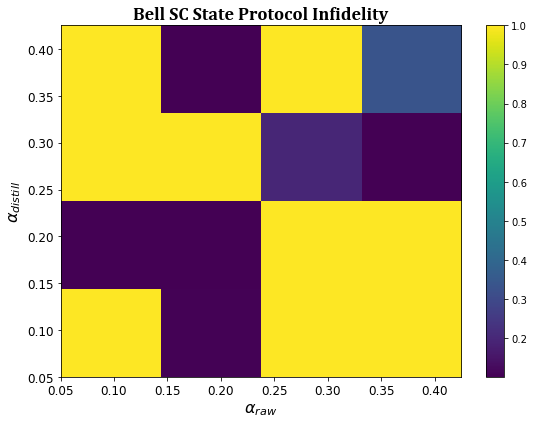

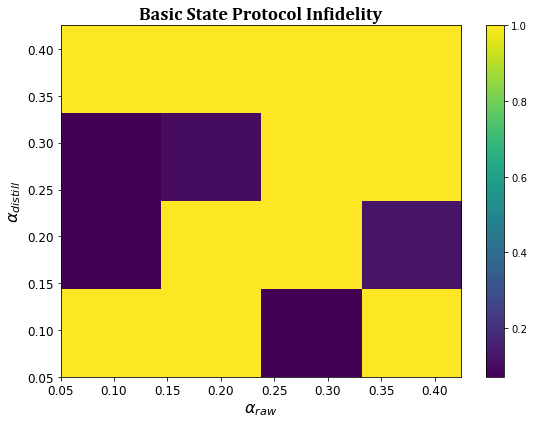

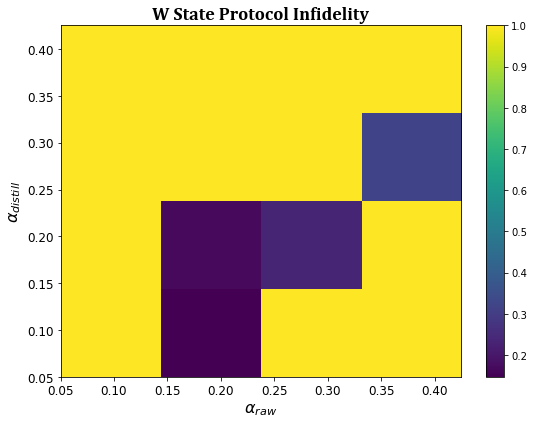

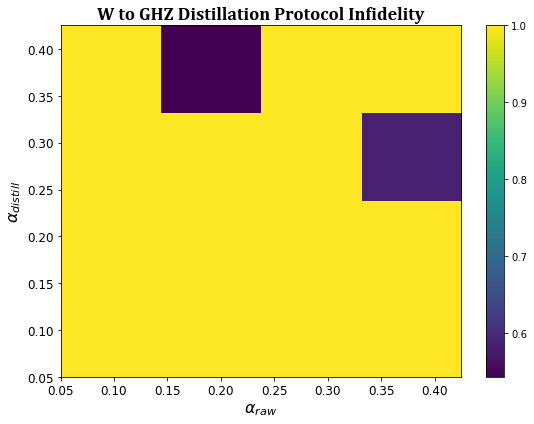

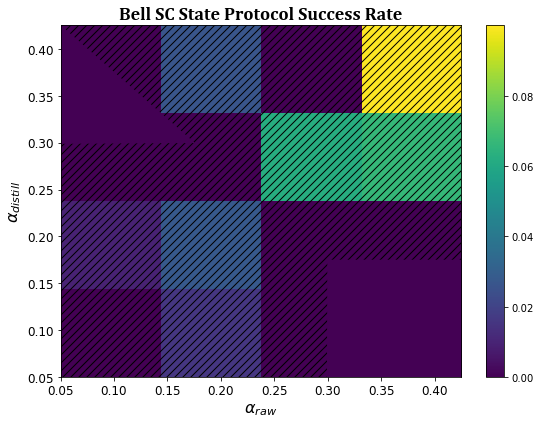

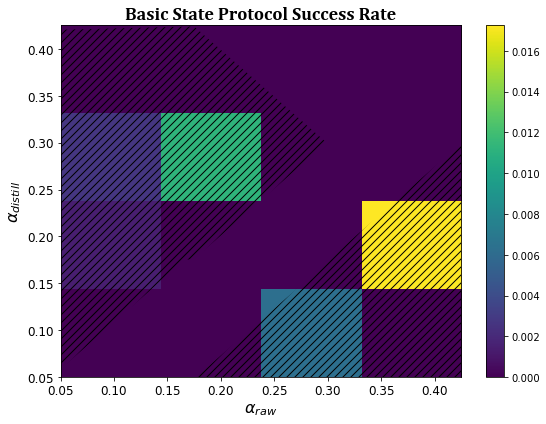

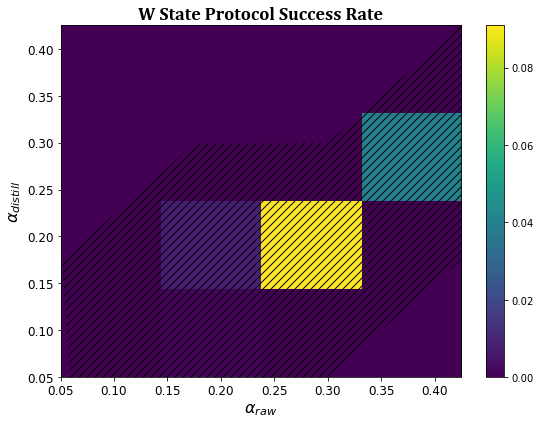

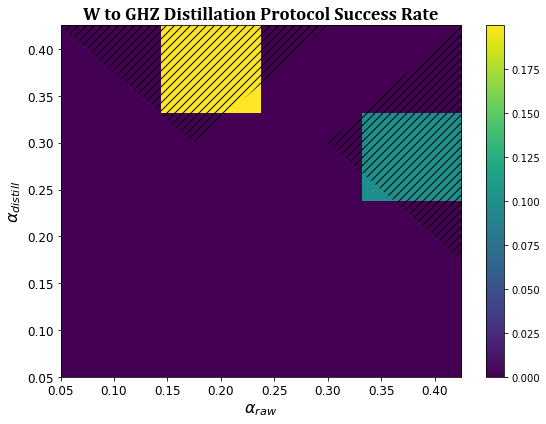

In [19]:
import matplotlib.pyplot as plt
import json
import numpy as np
import re

# Import the data from the json file
bright_state_raw_distillation_heatmap = rf"output_data\simulation_data\2025_06_29_22_52_46_data_bright_state_raw_distillation_heatmap_shots_1_pnr_True_Fprep_0.999_pDE_0.01_mu_0.95_cohtime_10_pg_0.001.json"
with open(bright_state_raw_distillation_heatmap, "r") as json_file:
    data = json.load(json_file)
    
# Extract the data from the json file
alpha_range = np.array(data["alpha_range"])
alpha_distill_range = np.array(data["alpha_distill_range"])
infidelity_bell_sc = np.array(data["infidelity_bell_sc"])
infidelity_basic = np.array(data["infidelity_basic"])
infidelity_w = np.array(data["infidelity_w"])
infidelity_w_to_GHZ_distill = np.array(data["infidelity_w_to_GHZ_distill"])
success_bell_sc = np.array(data["success_bell_sc"])
success_basic = np.array(data["success_basic"])
success_w = np.array(data["success_w"])
success_w_to_GHZ_distill = np.array(data["success_w_to_GHZ_distill"])
statistics_bell_sc = data["statistics_bell_sc"]
statistics_basic = data["statistics_basic"]
statistics_w = data["statistics_w"]
statistics_w_to_GHZ_distill = data["statistics_w_to_GHZ_distill"]

# Find shots from the file name
match_shots = re.search(r'shots_(\d+)', bright_state_raw_distillation_heatmap)
shots = int(match_shots.group(1))

# Plot and save heatmaps for infidelity for each protocol separately
protocols = [
    ("Bell SC State Protocol", infidelity_bell_sc),
    ("Basic State Protocol", infidelity_basic),
    ("W State Protocol", infidelity_w),
    ("W to GHZ Distillation Protocol", infidelity_w_to_GHZ_distill),
]
for name, infidelity in protocols:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('white')
    im = ax.imshow(
        infidelity,
        extent=[alpha_range.min(), alpha_range.max(), alpha_distill_range.min(), alpha_distill_range.max()],
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )
    ax.set_title(f'{name} Infidelity', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 18})
    ax.set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
    ax.set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
    ax.tick_params(axis='both', which='major', labelsize=12, labelcolor='black')
    fig.colorbar(im, ax=ax)
    # Add contour for infidelity <= 1e-2
    ax.contourf(
        alpha_range, alpha_distill_range, infidelity,
        levels=[0, 1e-2],
        hatches=['///'],
        colors='none',
        alpha=0
    )
    plt.tight_layout()
    fig.savefig(
        bright_state_raw_distillation_heatmap.replace(".json", f"_{name.replace(' ', '_').lower()}_infidelity_heatmap.pdf").replace("simulation_data", "figures"),
        dpi=300, bbox_inches='tight'
    )
    plt.show()
    plt.close(fig)

# Plot and save heatmaps for success probability for each protocol separately
protocols_success = [
    ("Bell SC State Protocol", success_bell_sc),
    ("Basic State Protocol", success_basic),
    ("W State Protocol", success_w),
    ("W to GHZ Distillation Protocol", success_w_to_GHZ_distill)
]
for name, success in protocols_success:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor('white')
    im = ax.imshow(
        success,
        extent=[alpha_range.min(), alpha_range.max(), alpha_distill_range.min(), alpha_distill_range.max()],
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )
    ax.set_title(f'{name} Success Rate', fontdict={'family': 'Cambria', 'weight': 'bold', 'size': 18})
    ax.set_xlabel(r'$\alpha_{raw}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
    ax.set_ylabel(r'$\alpha_{distill}$', fontsize=16, fontweight='bold', fontdict={'family': 'Cambria'})
    ax.tick_params(axis='both', which='major', labelsize=12, labelcolor='black')
    fig.colorbar(im, ax=ax)
    # Add contour for success >= 1e-4
    ax.contourf(
        alpha_range, alpha_distill_range, success,
        levels=[1e-4, np.max(success)],
        hatches=['///'],
        colors='none',
        alpha=0
    )
    plt.tight_layout()
    fig.savefig(
        bright_state_raw_distillation_heatmap.replace(".json", f"_{name.replace(' ', '_').lower()}_success_rates_heatmap.pdf").replace("simulation_data", "figures"),
        dpi=300, bbox_inches='tight'
    )
    plt.show()
    plt.close(fig)


# <a id='toc5_'></a>[Threshold calculations for direct emission scheme](#toc0_)

## <a id='toc5_1_'></a>[Shorten the names of superoperator files](#toc0_)

In [ ]:
# import os
# import shutil

# folder = r'C:\Users\ssingh8\OneDrive - Delft University of Technology\SIMULATIONS DATA\direct_emission_scheme_simulations\direct_double_click_scheme\1_rates_at_98'

# def copy_files(directory):
#     for filename in os.listdir(directory):
#         if filename.endswith("merged.csv"):
#             source = os.path.join(directory, filename)
#             destination = os.path.join(directory, "copy_" + filename)
#             shutil.copy2(source, destination)

# # for EM WT4
# def rename_files(directory):
#     for filename in os.listdir(directory):
#         if filename.startswith("copy_"):
#             bell_type = filename[filename.find("bell_pair_type-")+len("bell_pair_type-"):filename.rfind("_network_")]
#             nn_type =  filename[filename.find("network_noise_type-")+len("network_noise_type-"):filename.rfind("_p_g")]
#             set_parameters = filename[filename.find("hc_direct_ghz_node-")+len("hc_direct_ghz_node-"):filename.rfind("_bell_pair_type")]
#             pg_val = float(filename[filename.find("p_g-")+len("p_g-"):filename.rfind("_p_m")])
#             new_filename = filename.replace(filename, f"copy_{set_parameters}_bell_{bell_type}_nntype_{nn_type}_p_g-{pg_val}_p_m_.csv")
#             source = os.path.join(directory, filename)
#             destination = os.path.join(directory, new_filename)
#             os.rename(source, destination)


# copy_files(folder)
# rename_files(folder)

## <a id='toc5_2_'></a>[Threshold plots from the generated data](#toc0_)

This module creates the threshold plot for `data` generated via the 'Qsurface' package. Logical success data is supplied as commented lines for already reported results. 

In [ ]:
import pandas as pd
from oopsc.threshold.plot import plot_thresholds
from datetime import datetime
# Get current date and time in the format YYYYMMDDHHMMSS
timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")



### DATA FOR THE THRESHOLDS FOR DIFFERENT CASES ###

# Double-click direct emission
# 0 @ 98 with original bell pair parameters
# data = {"(4, 4)":{"0":[0.00005,0.64284],"1":[0.0001,0.6409],"2":[0.0005,0.60942],"3":[0.001,0.5809],"4":[0.0015,0.53956],"5":[0.002,0.50996]},"(6, 6)":{"0":[0.00005,0.3852],"1":[0.0001,0.37612],"2":[0.0005,0.33704],"3":[0.001,0.29494],"4":[0.0015,0.25572],"5":[0.002,0.22018]},"(8, 8)":{"0":[0.00005,0.18986],"1":[0.0001,0.18598],"2":[0.0005,0.15804],"3":[0.001,0.13186],"4":[0.0015,0.11334],"5":[0.002,0.09698]},"(10, 10)":{"0":[0.00005,0.09934],"1":[0.0001,0.10234],"2":[0.0005,0.0869],"3":[0.001,0.07768],"4":[0.0015,0.07004],"5":[0.002,0.0664]},"(12, 12)":{"0":[0.00005,0.07086],"1":[0.0001,0.07234],"2":[0.0005,0.0657],"3":[0.001,0.06424],"4":[0.0015,0.0644],"5":[0.002,0.06354]}}

# 1 @ 98 with new bell pair parameters with p_DE=0
data = {"(4, 4)":{"0":[0.00005,0.79228],"1":[0.0001,0.79154],"2":[0.0005,0.76666],"3":[0.001,0.7414],"4":[0.0015,0.71424],"5":[0.002,0.6822]},"(6, 6)":{"0":[0.00005,0.7833],"1":[0.0001,0.7787],"2":[0.0005,0.73188],"3":[0.001,0.6745],"4":[0.0015,0.60738],"5":[0.002,0.5455]},"(8, 8)":{"0":[0.00005,0.73468],"1":[0.0001,0.72748],"2":[0.0005,0.6573],"3":[0.001,0.56488],"4":[0.0015,0.47248],"5":[0.002,0.3894]},"(10, 10)":{"0":[0.00005,0.68044],"1":[0.0001,0.67048],"2":[0.0005,0.57212],"3":[0.001,0.44742],"4":[0.0015,0.33848],"5":[0.002,0.25002]},"(12, 12)":{"0":[0.00005,0.62314],"1":[0.0001,0.60478],"2":[0.0005,0.47804],"3":[0.001,0.3417],"4":[0.0015,0.23178],"5":[0.002,0.159]}}

#########################
## OLD DATA BELOW
# RAW FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = {"(4, 4)":{"0":[0.00001,0.14674],"1":[0.0001,0.14974],"2":[0.0005,0.14266],"3":[0.0008,0.13734],"4":[0.001,0.13724],"5":[0.002,0.12682],"6":[0.003,0.11836],"7":[0.004,0.11064]},"(6, 6)":{"0":[0.00001,0.07312],"1":[0.0001,0.0724],"2":[0.0005,0.07142],"3":[0.0008,0.06996],"4":[0.001,0.06756],"5":[0.002,0.06716],"6":[0.003,0.06568],"7":[0.004,0.06592]},"(8, 8)":{"0":[0.00001,0.06322],"1":[0.0001,0.06414],"2":[0.0005,0.0627],"3":[0.0008,0.0632],"4":[0.001,0.06374],"5":[0.002,0.06412],"6":[0.003,0.06404],"7":[0.004,0.06252]},"(10, 10)":{"0":[0.00001,0.06482],"1":[0.0001,0.0612],"2":[0.0005,0.06292],"3":[0.0008,0.0618],"4":[0.001,0.0615],"5":[0.002,0.0628],"6":[0.003,0.06246],"7":[0.004,0.06272]},"(12, 12)":{"0":[0.00001,0.06306],"1":[0.0001,0.06206],"2":[0.0005,0.06212],"3":[0.0008,0.06266],"4":[0.001,0.06216],"5":[0.002,0.06184],"6":[0.003,0.06158],"7":[0.004,0.06222]}}

# BASIC FIRST SIMULATION WITH NO-CUTOFF
# @ INF
# data = {"(4, 4)":{"0":[0.00001,0.9998],"1":[0.0001,0.99982],"2":[0.0005,0.9993],"3":[0.0008,0.99806],"4":[0.001,0.99732],"5":[0.002,0.99064],"6":[0.003,0.97748],"7":[0.004,0.95886]},"(6, 6)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,0.99976],"4":[0.001,0.99974],"5":[0.002,0.99804],"6":[0.003,0.9921],"7":[0.004,0.97586]},"(8, 8)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,0.99994],"5":[0.002,0.99948],"6":[0.003,0.99726],"7":[0.004,0.9865]},"(10, 10)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,1.0],"5":[0.002,0.99992],"6":[0.003,0.99878],"7":[0.004,0.99184]},"(12, 12)":{"0":[0.00001,1.0],"1":[0.0001,1.0],"2":[0.0005,1.0],"3":[0.0008,1.0],"4":[0.001,1.0],"5":[0.002,0.99996],"6":[0.003,0.99958],"7":[0.004,0.99578]}}
# data = {"(4, 4)":{"0":[0.004,0.95792],"1":[0.008,0.80982],"2":[0.015,0.43398],"3":[0.018,0.30888],"4":[0.02,0.24822],"5":[0.025,0.14874]},"(6, 6)":{"0":[0.004,0.97788],"1":[0.008,0.7354],"2":[0.015,0.1808],"3":[0.018,0.10596],"4":[0.02,0.08518],"5":[0.025,0.06764]},"(8, 8)":{"0":[0.004,0.98632],"1":[0.008,0.64612],"2":[0.015,0.08508],"3":[0.018,0.06686],"4":[0.02,0.06604],"5":[0.025,0.0619]},"(10, 10)":{"0":[0.004,0.9917],"1":[0.008,0.5464],"2":[0.015,0.06674],"3":[0.018,0.06224],"4":[0.02,0.06272],"5":[0.025,0.061]},"(12, 12)":{"0":[0.004,0.99568],"1":[0.008,0.44886],"2":[0.015,0.06368],"3":[0.018,0.06378],"4":[0.02,0.06434],"5":[0.025,0.06028]}}
# data = {"(4, 4)":{"1":[0.001,0.99744],"2":[0.002,0.98984],"3":[0.003,0.9784],"4":[0.004,0.95926],"5":[0.008,0.8081]},"(6, 6)":{"1":[0.001,0.99978],"2":[0.002,0.99814],"3":[0.003,0.99278],"4":[0.004,0.97702],"5":[0.008,0.73422]},"(8, 8)":{"1":[0.001,0.99996],"2":[0.002,0.99962],"3":[0.003,0.99716],"4":[0.004,0.98624],"5":[0.008,0.648]},"(10, 10)":{"1":[0.001,1.0],"2":[0.002,1.0],"3":[0.003,0.99888],"4":[0.004,0.99244],"5":[0.008,0.54708]},"(12, 12)":{"1":[0.001,1.0],"2":[0.002,0.99998],"3":[0.003,0.99956],"4":[0.004,0.99526],"5":[0.008,0.44674]}}


iters = 50000

rates = [rate[0] for rate in list(data["(6, 6)"].values())]

l4 = [rate[1] for rate in list(data["(4, 4)"].values())]
l6 = [rate[1] for rate in list(data["(6, 6)"].values())]
l8 = [rate[1] for rate in list(data["(8, 8)"].values())]
l10 = [rate[1] for rate in list(data["(10, 10)"].values())]
l12 = [rate[1] for rate in list(data["(12, 12)"].values())]

data_frame = pd.DataFrame(columns=["L", "p_g", "N", "success"])

for p_rate, success in zip(rates, l4):
    to_add = [4, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l6):
    to_add = [6, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l8):
    to_add = [8, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l10):
    to_add = [10, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add

for p_rate, success in zip(rates, l12):
    to_add = [12, p_rate, iters, success*iters]
    data_frame.loc[len(data_frame)] = to_add


data_frame = data_frame.set_index(["L", "p_g"])
plot_thresholds(data=data_frame, output=rf".\output_data\figures\{timestamp}_threshold_plot", modified_ansatz=False, accuracy=None)